# Forecasting problems

To discuss a couple of forecasting problems and explore their solutions.

### Corporación Favorita Grocery Sales Forecasting
https://www.kaggle.com/c/favorita-grocery-sales-forecasting    
To forecast Daily Unit Sales by store and product for a horizon of 1 to 16 days for more than 210,000 time series. The contestants had access to 55 months of data for the 54 stores and 3901 products, as well as metadata for the stores and products, promotion indicators, holiday information, and oil prices.

### Recruit Restaurant Visitor Forecasting
https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting   
To forecast Daily Restaurant Visits by restaurant for a horizon of 1 to 39 days. The contestants had access to 15 months of data for the 821 restaurants, as well as metadata for the restaurants, holiday information, and reservations for restaurant visits made at different times in advance.

### Wikipedia Web Traffic Forecasting
https://www.kaggle.com/c/web-traffic-time-series-forecasting   
To forecast daily Wikipedia page visits for a horizon of 12 to 42 days. The contestants had access to 32 months of data for the page visits, as well as metadata for the Wikipedia pages.

### Rossmann Store Sales
https://www.kaggle.com/c/rossmann-store-sales   
To forecast Daily Sales in dollars by store for a horizon of 1 to 48 days. The contestants had access to 31 months of data for the 1115 stores, as well as metadata for the stores, promotion indicators, holiday information, weather information, and Google Trend statistics

### Walmart Recruiting - Store Sales Forecasting
https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting   
To forecasts of Weekly Sales in dollars by department and store for a horizon of 1 to 39 weeks. The contestants had access to 33 months of data for the 45 stores and 81 departments, as well as metadata for the stores, holiday information, promotion indicators, weekly temperatures, fuel prices, consumer price index (CPI), and unemployment rate.

### Walmart Recruiting II: Sales in Stormy Weather
https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather   
To accurately predict the sales of 111 potentially weather-sensitive products (like umbrellas, bread, and milk) around the time of major weather events at 45 of their retail locations.

### M5 Forecasting - Accuracy
https://www.kaggle.com/c/m5-forecasting-accuracy   
To forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events..


# Corporación Favorita Grocery Sales Forecasting

https://www.kaggle.com/c/favorita-grocery-sales-forecasting

In [1]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [2]:
path_favorita = 'favorita-grocery-sales-forecasting/input/'

df_train = pd.read_csv(
    path_favorita+'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    path_favorita+"test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    path_favorita+"items.csv",
).set_index("item_nbr")

In [3]:
df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
del df_train

promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [4]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(t2017, is_train=True):
    X = pd.DataFrame({
        "day_1_2017": get_timespan(df_2017, t2017, 1, 1).values.ravel(),
        "mean_3_2017": get_timespan(df_2017, t2017, 3, 3).mean(axis=1).values,
        "mean_7_2017": get_timespan(df_2017, t2017, 7, 7).mean(axis=1).values,
        "mean_14_2017": get_timespan(df_2017, t2017, 14, 14).mean(axis=1).values,
        "mean_30_2017": get_timespan(df_2017, t2017, 30, 30).mean(axis=1).values,
        "mean_60_2017": get_timespan(df_2017, t2017, 60, 60).mean(axis=1).values,
        "mean_140_2017": get_timespan(df_2017, t2017, 140, 140).mean(axis=1).values,
        "promo_14_2017": get_timespan(promo_2017, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_2017, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_2017, t2017, 140, 140).sum(axis=1).values
    })
    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df_2017, t2017, 140-i, 20, freq='7D').mean(axis=1).values
    for i in range(16):
        X["promo_{}".format(i)] = promo_2017[
            t2017 + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_2017[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    return X

In [5]:
print("Preparing dataset...")

t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(6):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(
        t2017 + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l
X_val, y_val = prepare_dataset(date(2017, 7, 26))
X_test = prepare_dataset(date(2017, 8, 16), is_train=False)

Preparing dataset...


In [6]:
print("Training and predicting models...")

MAX_ROUNDS = 280
val_pred = []
test_pred = []
cate_vars = []

for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    model = CatBoostRegressor(
        iterations=MAX_ROUNDS, learning_rate=0.5,
        depth=4)
        
    model.fit(
        X_train, y_train[:, i],
        cat_features=cate_vars)
    
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

Training and predicting models...
Step 1
0:	learn: 0.7676832	total: 115ms	remaining: 32s
1:	learn: 0.6532021	total: 159ms	remaining: 22.1s
2:	learn: 0.6113439	total: 203ms	remaining: 18.7s
3:	learn: 0.5958956	total: 246ms	remaining: 17s
4:	learn: 0.5877026	total: 290ms	remaining: 16s
5:	learn: 0.5837279	total: 334ms	remaining: 15.3s
6:	learn: 0.5805493	total: 377ms	remaining: 14.7s
7:	learn: 0.5782491	total: 419ms	remaining: 14.3s
8:	learn: 0.5764057	total: 464ms	remaining: 14s
9:	learn: 0.5740496	total: 506ms	remaining: 13.7s
10:	learn: 0.5729414	total: 556ms	remaining: 13.6s
11:	learn: 0.5722020	total: 599ms	remaining: 13.4s
12:	learn: 0.5711638	total: 640ms	remaining: 13.1s
13:	learn: 0.5699681	total: 683ms	remaining: 13s
14:	learn: 0.5688545	total: 726ms	remaining: 12.8s
15:	learn: 0.5681261	total: 768ms	remaining: 12.7s
16:	learn: 0.5676064	total: 805ms	remaining: 12.5s
17:	learn: 0.5672531	total: 847ms	remaining: 12.3s
18:	learn: 0.5667647	total: 887ms	remaining: 12.2s
19:	learn:

161:	learn: 0.5511226	total: 6.91s	remaining: 5.04s
162:	learn: 0.5510945	total: 6.96s	remaining: 5s
163:	learn: 0.5510698	total: 7s	remaining: 4.95s
164:	learn: 0.5510433	total: 7.04s	remaining: 4.91s
165:	learn: 0.5510169	total: 7.08s	remaining: 4.87s
166:	learn: 0.5509905	total: 7.13s	remaining: 4.82s
167:	learn: 0.5509562	total: 7.17s	remaining: 4.78s
168:	learn: 0.5509104	total: 7.21s	remaining: 4.74s
169:	learn: 0.5508796	total: 7.25s	remaining: 4.69s
170:	learn: 0.5508374	total: 7.29s	remaining: 4.65s
171:	learn: 0.5507942	total: 7.33s	remaining: 4.61s
172:	learn: 0.5507488	total: 7.38s	remaining: 4.56s
173:	learn: 0.5507167	total: 7.42s	remaining: 4.52s
174:	learn: 0.5506826	total: 7.46s	remaining: 4.48s
175:	learn: 0.5506360	total: 7.5s	remaining: 4.43s
176:	learn: 0.5506114	total: 7.54s	remaining: 4.39s
177:	learn: 0.5505855	total: 7.59s	remaining: 4.35s
178:	learn: 0.5505512	total: 7.63s	remaining: 4.31s
179:	learn: 0.5505187	total: 7.68s	remaining: 4.27s
180:	learn: 0.55048

40:	learn: 0.5778968	total: 1.69s	remaining: 9.83s
41:	learn: 0.5777683	total: 1.73s	remaining: 9.8s
42:	learn: 0.5776027	total: 1.77s	remaining: 9.76s
43:	learn: 0.5774609	total: 1.81s	remaining: 9.69s
44:	learn: 0.5773091	total: 1.85s	remaining: 9.66s
45:	learn: 0.5772153	total: 1.89s	remaining: 9.63s
46:	learn: 0.5771232	total: 1.93s	remaining: 9.58s
47:	learn: 0.5770027	total: 1.97s	remaining: 9.54s
48:	learn: 0.5768416	total: 2.02s	remaining: 9.51s
49:	learn: 0.5767072	total: 2.06s	remaining: 9.48s
50:	learn: 0.5766149	total: 2.1s	remaining: 9.44s
51:	learn: 0.5765070	total: 2.14s	remaining: 9.4s
52:	learn: 0.5764394	total: 2.19s	remaining: 9.36s
53:	learn: 0.5763332	total: 2.23s	remaining: 9.31s
54:	learn: 0.5762437	total: 2.27s	remaining: 9.27s
55:	learn: 0.5761278	total: 2.31s	remaining: 9.26s
56:	learn: 0.5760432	total: 2.35s	remaining: 9.21s
57:	learn: 0.5759746	total: 2.39s	remaining: 9.14s
58:	learn: 0.5758776	total: 2.43s	remaining: 9.1s
59:	learn: 0.5757759	total: 2.47s	r

202:	learn: 0.5696797	total: 8.34s	remaining: 3.17s
203:	learn: 0.5696544	total: 8.38s	remaining: 3.12s
204:	learn: 0.5696230	total: 8.42s	remaining: 3.08s
205:	learn: 0.5695925	total: 8.47s	remaining: 3.04s
206:	learn: 0.5695652	total: 8.51s	remaining: 3s
207:	learn: 0.5695404	total: 8.55s	remaining: 2.96s
208:	learn: 0.5695095	total: 8.59s	remaining: 2.92s
209:	learn: 0.5695011	total: 8.63s	remaining: 2.88s
210:	learn: 0.5694768	total: 8.67s	remaining: 2.84s
211:	learn: 0.5694552	total: 8.71s	remaining: 2.79s
212:	learn: 0.5694396	total: 8.75s	remaining: 2.75s
213:	learn: 0.5694171	total: 8.8s	remaining: 2.71s
214:	learn: 0.5693939	total: 8.84s	remaining: 2.67s
215:	learn: 0.5693691	total: 8.88s	remaining: 2.63s
216:	learn: 0.5693572	total: 8.93s	remaining: 2.59s
217:	learn: 0.5693299	total: 8.97s	remaining: 2.55s
218:	learn: 0.5693078	total: 9.01s	remaining: 2.51s
219:	learn: 0.5692778	total: 9.05s	remaining: 2.47s
220:	learn: 0.5692582	total: 9.09s	remaining: 2.43s
221:	learn: 0.56

80:	learn: 0.5783091	total: 3.34s	remaining: 8.21s
81:	learn: 0.5782381	total: 3.38s	remaining: 8.16s
82:	learn: 0.5781866	total: 3.41s	remaining: 8.1s
83:	learn: 0.5781258	total: 3.46s	remaining: 8.06s
84:	learn: 0.5780690	total: 3.49s	remaining: 8.01s
85:	learn: 0.5780124	total: 3.53s	remaining: 7.96s
86:	learn: 0.5779587	total: 3.58s	remaining: 7.94s
87:	learn: 0.5778687	total: 3.62s	remaining: 7.9s
88:	learn: 0.5778096	total: 3.66s	remaining: 7.85s
89:	learn: 0.5777343	total: 3.7s	remaining: 7.81s
90:	learn: 0.5776838	total: 3.74s	remaining: 7.78s
91:	learn: 0.5776308	total: 3.78s	remaining: 7.73s
92:	learn: 0.5775519	total: 3.83s	remaining: 7.7s
93:	learn: 0.5775010	total: 3.87s	remaining: 7.65s
94:	learn: 0.5774435	total: 3.91s	remaining: 7.61s
95:	learn: 0.5773902	total: 3.96s	remaining: 7.58s
96:	learn: 0.5773506	total: 3.99s	remaining: 7.53s
97:	learn: 0.5773086	total: 4.04s	remaining: 7.5s
98:	learn: 0.5772314	total: 4.08s	remaining: 7.45s
99:	learn: 0.5771526	total: 4.11s	re

239:	learn: 0.5719850	total: 9.79s	remaining: 1.63s
240:	learn: 0.5719641	total: 9.83s	remaining: 1.59s
241:	learn: 0.5719479	total: 9.87s	remaining: 1.55s
242:	learn: 0.5719229	total: 9.91s	remaining: 1.51s
243:	learn: 0.5719015	total: 9.95s	remaining: 1.47s
244:	learn: 0.5718841	total: 9.99s	remaining: 1.43s
245:	learn: 0.5718493	total: 10s	remaining: 1.39s
246:	learn: 0.5718387	total: 10.1s	remaining: 1.34s
247:	learn: 0.5718256	total: 10.1s	remaining: 1.3s
248:	learn: 0.5718080	total: 10.1s	remaining: 1.26s
249:	learn: 0.5717883	total: 10.2s	remaining: 1.22s
250:	learn: 0.5717726	total: 10.2s	remaining: 1.18s
251:	learn: 0.5717372	total: 10.3s	remaining: 1.14s
252:	learn: 0.5717021	total: 10.3s	remaining: 1.1s
253:	learn: 0.5716811	total: 10.3s	remaining: 1.06s
254:	learn: 0.5716611	total: 10.4s	remaining: 1.02s
255:	learn: 0.5716414	total: 10.4s	remaining: 979ms
256:	learn: 0.5716107	total: 10.5s	remaining: 938ms
257:	learn: 0.5715883	total: 10.5s	remaining: 897ms
258:	learn: 0.57

120:	learn: 0.5952776	total: 4.99s	remaining: 6.56s
121:	learn: 0.5952281	total: 5.04s	remaining: 6.52s
122:	learn: 0.5951823	total: 5.08s	remaining: 6.49s
123:	learn: 0.5951378	total: 5.12s	remaining: 6.44s
124:	learn: 0.5950974	total: 5.16s	remaining: 6.4s
125:	learn: 0.5950539	total: 5.2s	remaining: 6.36s
126:	learn: 0.5950012	total: 5.25s	remaining: 6.32s
127:	learn: 0.5949511	total: 5.29s	remaining: 6.28s
128:	learn: 0.5949150	total: 5.32s	remaining: 6.23s
129:	learn: 0.5948952	total: 5.36s	remaining: 6.18s
130:	learn: 0.5948625	total: 5.41s	remaining: 6.15s
131:	learn: 0.5948275	total: 5.45s	remaining: 6.11s
132:	learn: 0.5946733	total: 5.49s	remaining: 6.06s
133:	learn: 0.5946326	total: 5.52s	remaining: 6.02s
134:	learn: 0.5945833	total: 5.56s	remaining: 5.98s
135:	learn: 0.5945180	total: 5.6s	remaining: 5.93s
136:	learn: 0.5944731	total: 5.64s	remaining: 5.89s
137:	learn: 0.5944373	total: 5.68s	remaining: 5.85s
138:	learn: 0.5943856	total: 5.73s	remaining: 5.81s
139:	learn: 0.5

Step 5
0:	learn: 0.8483203	total: 50.8ms	remaining: 14.2s
1:	learn: 0.7209078	total: 93ms	remaining: 12.9s
2:	learn: 0.6720702	total: 133ms	remaining: 12.2s
3:	learn: 0.6536566	total: 171ms	remaining: 11.8s
4:	learn: 0.6464244	total: 211ms	remaining: 11.6s
5:	learn: 0.6408255	total: 249ms	remaining: 11.4s
6:	learn: 0.6377476	total: 292ms	remaining: 11.4s
7:	learn: 0.6353140	total: 329ms	remaining: 11.2s
8:	learn: 0.6321208	total: 369ms	remaining: 11.1s
9:	learn: 0.6300296	total: 409ms	remaining: 11s
10:	learn: 0.6290235	total: 449ms	remaining: 11s
11:	learn: 0.6281158	total: 487ms	remaining: 10.9s
12:	learn: 0.6272449	total: 527ms	remaining: 10.8s
13:	learn: 0.6256527	total: 570ms	remaining: 10.8s
14:	learn: 0.6247693	total: 614ms	remaining: 10.8s
15:	learn: 0.6239014	total: 653ms	remaining: 10.8s
16:	learn: 0.6230376	total: 702ms	remaining: 10.9s
17:	learn: 0.6222050	total: 741ms	remaining: 10.8s
18:	learn: 0.6213405	total: 780ms	remaining: 10.7s
19:	learn: 0.6207786	total: 817ms	rema

160:	learn: 0.6026896	total: 6.54s	remaining: 4.83s
161:	learn: 0.6026717	total: 6.58s	remaining: 4.79s
162:	learn: 0.6026384	total: 6.61s	remaining: 4.75s
163:	learn: 0.6026087	total: 6.65s	remaining: 4.71s
164:	learn: 0.6024871	total: 6.69s	remaining: 4.66s
165:	learn: 0.6024558	total: 6.73s	remaining: 4.62s
166:	learn: 0.6024066	total: 6.77s	remaining: 4.58s
167:	learn: 0.6023587	total: 6.81s	remaining: 4.54s
168:	learn: 0.6023225	total: 6.85s	remaining: 4.5s
169:	learn: 0.6022860	total: 6.88s	remaining: 4.46s
170:	learn: 0.6022582	total: 6.92s	remaining: 4.41s
171:	learn: 0.6022283	total: 6.97s	remaining: 4.37s
172:	learn: 0.6022013	total: 7.01s	remaining: 4.33s
173:	learn: 0.6021601	total: 7.05s	remaining: 4.29s
174:	learn: 0.6021210	total: 7.09s	remaining: 4.25s
175:	learn: 0.6020914	total: 7.13s	remaining: 4.21s
176:	learn: 0.6020573	total: 7.17s	remaining: 4.17s
177:	learn: 0.6019722	total: 7.2s	remaining: 4.13s
178:	learn: 0.6019050	total: 7.24s	remaining: 4.08s
179:	learn: 0.

40:	learn: 0.6039194	total: 1.69s	remaining: 9.83s
41:	learn: 0.6037384	total: 1.72s	remaining: 9.77s
42:	learn: 0.6035923	total: 1.77s	remaining: 9.74s
43:	learn: 0.6034634	total: 1.81s	remaining: 9.71s
44:	learn: 0.6033097	total: 1.85s	remaining: 9.66s
45:	learn: 0.6031121	total: 1.89s	remaining: 9.61s
46:	learn: 0.6029916	total: 1.93s	remaining: 9.57s
47:	learn: 0.6028716	total: 1.98s	remaining: 9.55s
48:	learn: 0.6027194	total: 2.02s	remaining: 9.51s
49:	learn: 0.6025572	total: 2.05s	remaining: 9.45s
50:	learn: 0.6024383	total: 2.1s	remaining: 9.42s
51:	learn: 0.6023046	total: 2.14s	remaining: 9.37s
52:	learn: 0.6022049	total: 2.18s	remaining: 9.33s
53:	learn: 0.6021233	total: 2.21s	remaining: 9.27s
54:	learn: 0.6019495	total: 2.25s	remaining: 9.23s
55:	learn: 0.6018648	total: 2.29s	remaining: 9.17s
56:	learn: 0.6017488	total: 2.33s	remaining: 9.14s
57:	learn: 0.6014918	total: 2.37s	remaining: 9.09s
58:	learn: 0.6013577	total: 2.41s	remaining: 9.04s
59:	learn: 0.6012562	total: 2.46

202:	learn: 0.5944514	total: 8.28s	remaining: 3.14s
203:	learn: 0.5944235	total: 8.32s	remaining: 3.1s
204:	learn: 0.5943810	total: 8.36s	remaining: 3.06s
205:	learn: 0.5943460	total: 8.41s	remaining: 3.02s
206:	learn: 0.5943134	total: 8.45s	remaining: 2.98s
207:	learn: 0.5942953	total: 8.49s	remaining: 2.94s
208:	learn: 0.5942736	total: 8.53s	remaining: 2.9s
209:	learn: 0.5942406	total: 8.57s	remaining: 2.86s
210:	learn: 0.5942102	total: 8.61s	remaining: 2.81s
211:	learn: 0.5941903	total: 8.65s	remaining: 2.77s
212:	learn: 0.5941612	total: 8.69s	remaining: 2.73s
213:	learn: 0.5941367	total: 8.73s	remaining: 2.69s
214:	learn: 0.5941101	total: 8.77s	remaining: 2.65s
215:	learn: 0.5940764	total: 8.81s	remaining: 2.61s
216:	learn: 0.5940560	total: 8.85s	remaining: 2.57s
217:	learn: 0.5940171	total: 8.89s	remaining: 2.53s
218:	learn: 0.5939858	total: 8.93s	remaining: 2.49s
219:	learn: 0.5939679	total: 8.97s	remaining: 2.45s
220:	learn: 0.5939404	total: 9.01s	remaining: 2.4s
221:	learn: 0.5

82:	learn: 0.5927040	total: 3.35s	remaining: 7.96s
83:	learn: 0.5926300	total: 3.4s	remaining: 7.92s
84:	learn: 0.5925543	total: 3.43s	remaining: 7.87s
85:	learn: 0.5924932	total: 3.47s	remaining: 7.83s
86:	learn: 0.5924381	total: 3.52s	remaining: 7.8s
87:	learn: 0.5923835	total: 3.56s	remaining: 7.76s
88:	learn: 0.5923361	total: 3.6s	remaining: 7.73s
89:	learn: 0.5922692	total: 3.64s	remaining: 7.68s
90:	learn: 0.5922103	total: 3.67s	remaining: 7.63s
91:	learn: 0.5921748	total: 3.72s	remaining: 7.6s
92:	learn: 0.5921053	total: 3.76s	remaining: 7.56s
93:	learn: 0.5920579	total: 3.8s	remaining: 7.52s
94:	learn: 0.5919906	total: 3.84s	remaining: 7.48s
95:	learn: 0.5919386	total: 3.88s	remaining: 7.45s
96:	learn: 0.5918856	total: 3.92s	remaining: 7.4s
97:	learn: 0.5918293	total: 3.96s	remaining: 7.36s
98:	learn: 0.5917863	total: 4s	remaining: 7.32s
99:	learn: 0.5916677	total: 4.04s	remaining: 7.28s
100:	learn: 0.5915990	total: 4.08s	remaining: 7.23s
101:	learn: 0.5915344	total: 4.12s	rema

243:	learn: 0.5865661	total: 9.82s	remaining: 1.45s
244:	learn: 0.5865370	total: 9.86s	remaining: 1.41s
245:	learn: 0.5865233	total: 9.89s	remaining: 1.37s
246:	learn: 0.5865059	total: 9.94s	remaining: 1.33s
247:	learn: 0.5864793	total: 9.98s	remaining: 1.29s
248:	learn: 0.5864575	total: 10s	remaining: 1.25s
249:	learn: 0.5864167	total: 10.1s	remaining: 1.21s
250:	learn: 0.5863860	total: 10.1s	remaining: 1.17s
251:	learn: 0.5863627	total: 10.1s	remaining: 1.13s
252:	learn: 0.5863330	total: 10.2s	remaining: 1.08s
253:	learn: 0.5863195	total: 10.2s	remaining: 1.04s
254:	learn: 0.5862908	total: 10.3s	remaining: 1s
255:	learn: 0.5862679	total: 10.3s	remaining: 965ms
256:	learn: 0.5862545	total: 10.3s	remaining: 925ms
257:	learn: 0.5862396	total: 10.4s	remaining: 884ms
258:	learn: 0.5862177	total: 10.4s	remaining: 844ms
259:	learn: 0.5861969	total: 10.5s	remaining: 805ms
260:	learn: 0.5861841	total: 10.5s	remaining: 764ms
261:	learn: 0.5861642	total: 10.5s	remaining: 723ms
262:	learn: 0.586

126:	learn: 0.5802067	total: 5.15s	remaining: 6.2s
127:	learn: 0.5801689	total: 5.19s	remaining: 6.16s
128:	learn: 0.5801387	total: 5.23s	remaining: 6.12s
129:	learn: 0.5800873	total: 5.27s	remaining: 6.08s
130:	learn: 0.5800315	total: 5.31s	remaining: 6.04s
131:	learn: 0.5799768	total: 5.35s	remaining: 5.99s
132:	learn: 0.5799437	total: 5.38s	remaining: 5.95s
133:	learn: 0.5798938	total: 5.42s	remaining: 5.91s
134:	learn: 0.5798504	total: 5.46s	remaining: 5.87s
135:	learn: 0.5798211	total: 5.5s	remaining: 5.82s
136:	learn: 0.5797941	total: 5.54s	remaining: 5.78s
137:	learn: 0.5797414	total: 5.58s	remaining: 5.75s
138:	learn: 0.5796675	total: 5.62s	remaining: 5.7s
139:	learn: 0.5796357	total: 5.66s	remaining: 5.66s
140:	learn: 0.5795940	total: 5.7s	remaining: 5.62s
141:	learn: 0.5795471	total: 5.74s	remaining: 5.57s
142:	learn: 0.5794849	total: 5.78s	remaining: 5.54s
143:	learn: 0.5794639	total: 5.82s	remaining: 5.49s
144:	learn: 0.5794446	total: 5.86s	remaining: 5.46s
145:	learn: 0.57

6:	learn: 0.6097067	total: 288ms	remaining: 11.2s
7:	learn: 0.6079095	total: 329ms	remaining: 11.2s
8:	learn: 0.6058035	total: 367ms	remaining: 11s
9:	learn: 0.6039227	total: 402ms	remaining: 10.9s
10:	learn: 0.6030923	total: 441ms	remaining: 10.8s
11:	learn: 0.6022398	total: 489ms	remaining: 10.9s
12:	learn: 0.6012235	total: 528ms	remaining: 10.8s
13:	learn: 0.6004802	total: 568ms	remaining: 10.8s
14:	learn: 0.5999927	total: 606ms	remaining: 10.7s
15:	learn: 0.5995848	total: 642ms	remaining: 10.6s
16:	learn: 0.5989907	total: 688ms	remaining: 10.6s
17:	learn: 0.5983553	total: 728ms	remaining: 10.6s
18:	learn: 0.5977028	total: 768ms	remaining: 10.6s
19:	learn: 0.5974243	total: 805ms	remaining: 10.5s
20:	learn: 0.5968635	total: 847ms	remaining: 10.4s
21:	learn: 0.5964139	total: 886ms	remaining: 10.4s
22:	learn: 0.5961074	total: 929ms	remaining: 10.4s
23:	learn: 0.5957748	total: 968ms	remaining: 10.3s
24:	learn: 0.5954430	total: 1.01s	remaining: 10.3s
25:	learn: 0.5950985	total: 1.05s	rem

172:	learn: 0.5842096	total: 7.02s	remaining: 4.34s
173:	learn: 0.5841756	total: 7.06s	remaining: 4.3s
174:	learn: 0.5841377	total: 7.1s	remaining: 4.26s
175:	learn: 0.5841081	total: 7.14s	remaining: 4.22s
176:	learn: 0.5840871	total: 7.18s	remaining: 4.18s
177:	learn: 0.5840550	total: 7.22s	remaining: 4.14s
178:	learn: 0.5840194	total: 7.26s	remaining: 4.1s
179:	learn: 0.5839915	total: 7.3s	remaining: 4.06s
180:	learn: 0.5839578	total: 7.35s	remaining: 4.02s
181:	learn: 0.5839262	total: 7.39s	remaining: 3.98s
182:	learn: 0.5838933	total: 7.43s	remaining: 3.94s
183:	learn: 0.5838661	total: 7.47s	remaining: 3.9s
184:	learn: 0.5838314	total: 7.51s	remaining: 3.86s
185:	learn: 0.5838048	total: 7.56s	remaining: 3.82s
186:	learn: 0.5837789	total: 7.6s	remaining: 3.78s
187:	learn: 0.5837427	total: 7.64s	remaining: 3.74s
188:	learn: 0.5837281	total: 7.68s	remaining: 3.7s
189:	learn: 0.5836975	total: 7.72s	remaining: 3.65s
190:	learn: 0.5836712	total: 7.75s	remaining: 3.61s
191:	learn: 0.58364

50:	learn: 0.5968842	total: 2.1s	remaining: 9.42s
51:	learn: 0.5967267	total: 2.14s	remaining: 9.38s
52:	learn: 0.5965710	total: 2.18s	remaining: 9.34s
53:	learn: 0.5964613	total: 2.22s	remaining: 9.29s
54:	learn: 0.5962954	total: 2.26s	remaining: 9.25s
55:	learn: 0.5961679	total: 2.3s	remaining: 9.22s
56:	learn: 0.5960077	total: 2.34s	remaining: 9.16s
57:	learn: 0.5959198	total: 2.38s	remaining: 9.11s
58:	learn: 0.5958012	total: 2.42s	remaining: 9.07s
59:	learn: 0.5956945	total: 2.46s	remaining: 9.02s
60:	learn: 0.5956005	total: 2.51s	remaining: 9s
61:	learn: 0.5955132	total: 2.55s	remaining: 8.97s
62:	learn: 0.5954280	total: 2.6s	remaining: 8.96s
63:	learn: 0.5953447	total: 2.64s	remaining: 8.9s
64:	learn: 0.5952767	total: 2.68s	remaining: 8.85s
65:	learn: 0.5952182	total: 2.71s	remaining: 8.8s
66:	learn: 0.5950353	total: 2.75s	remaining: 8.74s
67:	learn: 0.5949285	total: 2.79s	remaining: 8.72s
68:	learn: 0.5946896	total: 2.84s	remaining: 8.68s
69:	learn: 0.5944795	total: 2.88s	remai

215:	learn: 0.5873239	total: 8.81s	remaining: 2.61s
216:	learn: 0.5872895	total: 8.85s	remaining: 2.57s
217:	learn: 0.5872541	total: 8.89s	remaining: 2.53s
218:	learn: 0.5872329	total: 8.92s	remaining: 2.48s
219:	learn: 0.5872002	total: 8.97s	remaining: 2.45s
220:	learn: 0.5871722	total: 9.01s	remaining: 2.4s
221:	learn: 0.5871472	total: 9.05s	remaining: 2.36s
222:	learn: 0.5870976	total: 9.09s	remaining: 2.32s
223:	learn: 0.5870682	total: 9.13s	remaining: 2.28s
224:	learn: 0.5870275	total: 9.17s	remaining: 2.24s
225:	learn: 0.5870083	total: 9.21s	remaining: 2.2s
226:	learn: 0.5869863	total: 9.25s	remaining: 2.16s
227:	learn: 0.5869535	total: 9.29s	remaining: 2.12s
228:	learn: 0.5869314	total: 9.34s	remaining: 2.08s
229:	learn: 0.5868975	total: 9.37s	remaining: 2.04s
230:	learn: 0.5868667	total: 9.41s	remaining: 2s
231:	learn: 0.5868449	total: 9.45s	remaining: 1.96s
232:	learn: 0.5868167	total: 9.49s	remaining: 1.91s
233:	learn: 0.5867933	total: 9.53s	remaining: 1.87s
234:	learn: 0.586

96:	learn: 0.6151875	total: 3.94s	remaining: 7.43s
97:	learn: 0.6151361	total: 3.98s	remaining: 7.39s
98:	learn: 0.6150447	total: 4.02s	remaining: 7.34s
99:	learn: 0.6149855	total: 4.05s	remaining: 7.29s
100:	learn: 0.6149223	total: 4.09s	remaining: 7.25s
101:	learn: 0.6148678	total: 4.13s	remaining: 7.21s
102:	learn: 0.6147337	total: 4.17s	remaining: 7.17s
103:	learn: 0.6146425	total: 4.21s	remaining: 7.13s
104:	learn: 0.6145721	total: 4.25s	remaining: 7.09s
105:	learn: 0.6145293	total: 4.29s	remaining: 7.05s
106:	learn: 0.6144804	total: 4.34s	remaining: 7.01s
107:	learn: 0.6144329	total: 4.38s	remaining: 6.97s
108:	learn: 0.6143939	total: 4.42s	remaining: 6.93s
109:	learn: 0.6143534	total: 4.46s	remaining: 6.89s
110:	learn: 0.6143148	total: 4.5s	remaining: 6.85s
111:	learn: 0.6142784	total: 4.54s	remaining: 6.81s
112:	learn: 0.6142361	total: 4.58s	remaining: 6.77s
113:	learn: 0.6141753	total: 4.62s	remaining: 6.72s
114:	learn: 0.6141275	total: 4.66s	remaining: 6.69s
115:	learn: 0.614

256:	learn: 0.6087693	total: 10.4s	remaining: 935ms
257:	learn: 0.6087328	total: 10.5s	remaining: 895ms
258:	learn: 0.6087080	total: 10.5s	remaining: 854ms
259:	learn: 0.6086772	total: 10.6s	remaining: 813ms
260:	learn: 0.6086487	total: 10.6s	remaining: 773ms
261:	learn: 0.6086172	total: 10.7s	remaining: 732ms
262:	learn: 0.6085776	total: 10.7s	remaining: 691ms
263:	learn: 0.6085525	total: 10.7s	remaining: 651ms
264:	learn: 0.6085269	total: 10.8s	remaining: 610ms
265:	learn: 0.6085045	total: 10.8s	remaining: 569ms
266:	learn: 0.6084804	total: 10.8s	remaining: 528ms
267:	learn: 0.6084575	total: 10.9s	remaining: 488ms
268:	learn: 0.6084343	total: 10.9s	remaining: 447ms
269:	learn: 0.6084058	total: 11s	remaining: 407ms
270:	learn: 0.6083775	total: 11s	remaining: 366ms
271:	learn: 0.6083562	total: 11.1s	remaining: 325ms
272:	learn: 0.6083378	total: 11.1s	remaining: 284ms
273:	learn: 0.6083220	total: 11.1s	remaining: 244ms
274:	learn: 0.6082991	total: 11.2s	remaining: 203ms
275:	learn: 0.60

138:	learn: 0.6213477	total: 5.69s	remaining: 5.77s
139:	learn: 0.6213126	total: 5.73s	remaining: 5.73s
140:	learn: 0.6212723	total: 5.77s	remaining: 5.69s
141:	learn: 0.6212461	total: 5.82s	remaining: 5.65s
142:	learn: 0.6212057	total: 5.85s	remaining: 5.61s
143:	learn: 0.6211437	total: 5.89s	remaining: 5.57s
144:	learn: 0.6210938	total: 5.94s	remaining: 5.53s
145:	learn: 0.6210724	total: 5.98s	remaining: 5.49s
146:	learn: 0.6210311	total: 6.03s	remaining: 5.45s
147:	learn: 0.6210021	total: 6.07s	remaining: 5.41s
148:	learn: 0.6209611	total: 6.11s	remaining: 5.37s
149:	learn: 0.6209112	total: 6.16s	remaining: 5.34s
150:	learn: 0.6208660	total: 6.2s	remaining: 5.29s
151:	learn: 0.6208341	total: 6.24s	remaining: 5.25s
152:	learn: 0.6207723	total: 6.28s	remaining: 5.21s
153:	learn: 0.6207358	total: 6.32s	remaining: 5.17s
154:	learn: 0.6206850	total: 6.36s	remaining: 5.13s
155:	learn: 0.6206401	total: 6.4s	remaining: 5.09s
156:	learn: 0.6206008	total: 6.44s	remaining: 5.05s
157:	learn: 0.

15:	learn: 0.6245418	total: 677ms	remaining: 11.2s
16:	learn: 0.6238947	total: 727ms	remaining: 11.2s
17:	learn: 0.6234866	total: 768ms	remaining: 11.2s
18:	learn: 0.6232194	total: 805ms	remaining: 11.1s
19:	learn: 0.6226643	total: 850ms	remaining: 11s
20:	learn: 0.6222047	total: 888ms	remaining: 11s
21:	learn: 0.6215618	total: 933ms	remaining: 10.9s
22:	learn: 0.6210916	total: 974ms	remaining: 10.9s
23:	learn: 0.6207063	total: 1.02s	remaining: 10.8s
24:	learn: 0.6204772	total: 1.05s	remaining: 10.8s
25:	learn: 0.6202044	total: 1.1s	remaining: 10.7s
26:	learn: 0.6198241	total: 1.14s	remaining: 10.7s
27:	learn: 0.6195298	total: 1.18s	remaining: 10.7s
28:	learn: 0.6193046	total: 1.22s	remaining: 10.6s
29:	learn: 0.6190153	total: 1.26s	remaining: 10.5s
30:	learn: 0.6188323	total: 1.31s	remaining: 10.5s
31:	learn: 0.6186439	total: 1.35s	remaining: 10.5s
32:	learn: 0.6183525	total: 1.39s	remaining: 10.4s
33:	learn: 0.6182032	total: 1.43s	remaining: 10.3s
34:	learn: 0.6179555	total: 1.47s	re

175:	learn: 0.6075570	total: 7.16s	remaining: 4.23s
176:	learn: 0.6075294	total: 7.2s	remaining: 4.19s
177:	learn: 0.6074895	total: 7.24s	remaining: 4.15s
178:	learn: 0.6074476	total: 7.28s	remaining: 4.11s
179:	learn: 0.6074177	total: 7.32s	remaining: 4.07s
180:	learn: 0.6073856	total: 7.36s	remaining: 4.03s
181:	learn: 0.6073547	total: 7.4s	remaining: 3.99s
182:	learn: 0.6073232	total: 7.45s	remaining: 3.95s
183:	learn: 0.6072868	total: 7.49s	remaining: 3.91s
184:	learn: 0.6072602	total: 7.53s	remaining: 3.87s
185:	learn: 0.6072281	total: 7.58s	remaining: 3.83s
186:	learn: 0.6071982	total: 7.62s	remaining: 3.79s
187:	learn: 0.6071718	total: 7.65s	remaining: 3.74s
188:	learn: 0.6071362	total: 7.69s	remaining: 3.7s
189:	learn: 0.6071098	total: 7.73s	remaining: 3.66s
190:	learn: 0.6070907	total: 7.76s	remaining: 3.62s
191:	learn: 0.6070599	total: 7.81s	remaining: 3.58s
192:	learn: 0.6070205	total: 7.85s	remaining: 3.54s
193:	learn: 0.6069966	total: 7.89s	remaining: 3.5s
194:	learn: 0.60

55:	learn: 0.6065547	total: 2.29s	remaining: 9.14s
56:	learn: 0.6064874	total: 2.32s	remaining: 9.09s
57:	learn: 0.6063868	total: 2.36s	remaining: 9.04s
58:	learn: 0.6063042	total: 2.4s	remaining: 9s
59:	learn: 0.6061583	total: 2.44s	remaining: 8.96s
60:	learn: 0.6060646	total: 2.48s	remaining: 8.92s
61:	learn: 0.6059437	total: 2.52s	remaining: 8.87s
62:	learn: 0.6058676	total: 2.56s	remaining: 8.82s
63:	learn: 0.6057671	total: 2.6s	remaining: 8.78s
64:	learn: 0.6056606	total: 2.64s	remaining: 8.74s
65:	learn: 0.6055281	total: 2.68s	remaining: 8.69s
66:	learn: 0.6054518	total: 2.73s	remaining: 8.67s
67:	learn: 0.6053700	total: 2.77s	remaining: 8.62s
68:	learn: 0.6053147	total: 2.8s	remaining: 8.57s
69:	learn: 0.6052669	total: 2.84s	remaining: 8.53s
70:	learn: 0.6051829	total: 2.88s	remaining: 8.48s
71:	learn: 0.6050672	total: 2.92s	remaining: 8.44s
72:	learn: 0.6049094	total: 2.96s	remaining: 8.39s
73:	learn: 0.6047897	total: 3s	remaining: 8.35s
74:	learn: 0.6047073	total: 3.04s	remain

218:	learn: 0.5985541	total: 8.97s	remaining: 2.5s
219:	learn: 0.5985310	total: 9.01s	remaining: 2.46s
220:	learn: 0.5985129	total: 9.05s	remaining: 2.42s
221:	learn: 0.5984818	total: 9.09s	remaining: 2.38s
222:	learn: 0.5984504	total: 9.13s	remaining: 2.33s
223:	learn: 0.5984206	total: 9.18s	remaining: 2.29s
224:	learn: 0.5983968	total: 9.22s	remaining: 2.25s
225:	learn: 0.5983756	total: 9.26s	remaining: 2.21s
226:	learn: 0.5983522	total: 9.3s	remaining: 2.17s
227:	learn: 0.5982934	total: 9.34s	remaining: 2.13s
228:	learn: 0.5982699	total: 9.38s	remaining: 2.09s
229:	learn: 0.5982437	total: 9.43s	remaining: 2.05s
230:	learn: 0.5982195	total: 9.47s	remaining: 2.01s
231:	learn: 0.5981986	total: 9.51s	remaining: 1.97s
232:	learn: 0.5981725	total: 9.55s	remaining: 1.93s
233:	learn: 0.5981490	total: 9.6s	remaining: 1.89s
234:	learn: 0.5981205	total: 9.63s	remaining: 1.84s
235:	learn: 0.5980969	total: 9.67s	remaining: 1.8s
236:	learn: 0.5980794	total: 9.71s	remaining: 1.76s
237:	learn: 0.59

98:	learn: 0.5942992	total: 3.96s	remaining: 7.25s
99:	learn: 0.5942308	total: 4s	remaining: 7.21s
100:	learn: 0.5941495	total: 4.05s	remaining: 7.17s
101:	learn: 0.5941231	total: 4.09s	remaining: 7.14s
102:	learn: 0.5940664	total: 4.13s	remaining: 7.1s
103:	learn: 0.5940089	total: 4.17s	remaining: 7.06s
104:	learn: 0.5939666	total: 4.21s	remaining: 7.02s
105:	learn: 0.5939112	total: 4.25s	remaining: 6.98s
106:	learn: 0.5938640	total: 4.29s	remaining: 6.94s
107:	learn: 0.5938175	total: 4.33s	remaining: 6.89s
108:	learn: 0.5937512	total: 4.37s	remaining: 6.85s
109:	learn: 0.5937032	total: 4.41s	remaining: 6.81s
110:	learn: 0.5936475	total: 4.45s	remaining: 6.77s
111:	learn: 0.5935972	total: 4.49s	remaining: 6.73s
112:	learn: 0.5935372	total: 4.53s	remaining: 6.69s
113:	learn: 0.5934972	total: 4.57s	remaining: 6.65s
114:	learn: 0.5934458	total: 4.61s	remaining: 6.61s
115:	learn: 0.5934237	total: 4.65s	remaining: 6.57s
116:	learn: 0.5933847	total: 4.69s	remaining: 6.54s
117:	learn: 0.5933

258:	learn: 0.5885826	total: 10.4s	remaining: 843ms
259:	learn: 0.5885659	total: 10.4s	remaining: 803ms
260:	learn: 0.5885453	total: 10.5s	remaining: 763ms
261:	learn: 0.5885227	total: 10.5s	remaining: 722ms
262:	learn: 0.5884926	total: 10.6s	remaining: 682ms
263:	learn: 0.5884376	total: 10.6s	remaining: 643ms
264:	learn: 0.5884127	total: 10.6s	remaining: 602ms
265:	learn: 0.5883879	total: 10.7s	remaining: 562ms
266:	learn: 0.5883670	total: 10.7s	remaining: 522ms
267:	learn: 0.5883452	total: 10.8s	remaining: 482ms
268:	learn: 0.5883251	total: 10.8s	remaining: 442ms
269:	learn: 0.5883046	total: 10.8s	remaining: 401ms
270:	learn: 0.5882886	total: 10.9s	remaining: 361ms
271:	learn: 0.5882701	total: 10.9s	remaining: 321ms
272:	learn: 0.5882614	total: 11s	remaining: 281ms
273:	learn: 0.5882365	total: 11s	remaining: 241ms
274:	learn: 0.5882249	total: 11s	remaining: 201ms
275:	learn: 0.5882048	total: 11.1s	remaining: 161ms
276:	learn: 0.5881880	total: 11.1s	remaining: 120ms
277:	learn: 0.5881

141:	learn: 0.5981721	total: 5.68s	remaining: 5.52s
142:	learn: 0.5981422	total: 5.72s	remaining: 5.48s
143:	learn: 0.5980992	total: 5.75s	remaining: 5.43s
144:	learn: 0.5980754	total: 5.79s	remaining: 5.39s
145:	learn: 0.5980104	total: 5.84s	remaining: 5.36s
146:	learn: 0.5979780	total: 5.88s	remaining: 5.32s
147:	learn: 0.5979187	total: 5.92s	remaining: 5.28s
148:	learn: 0.5978727	total: 5.96s	remaining: 5.24s
149:	learn: 0.5978255	total: 6s	remaining: 5.2s
150:	learn: 0.5977912	total: 6.04s	remaining: 5.16s
151:	learn: 0.5977679	total: 6.09s	remaining: 5.13s
152:	learn: 0.5977251	total: 6.13s	remaining: 5.08s
153:	learn: 0.5976875	total: 6.16s	remaining: 5.04s
154:	learn: 0.5976468	total: 6.2s	remaining: 5s
155:	learn: 0.5976139	total: 6.24s	remaining: 4.96s
156:	learn: 0.5975848	total: 6.28s	remaining: 4.92s
157:	learn: 0.5975540	total: 6.32s	remaining: 4.88s
158:	learn: 0.5975246	total: 6.35s	remaining: 4.83s
159:	learn: 0.5974925	total: 6.4s	remaining: 4.8s
160:	learn: 0.5974643	

In [7]:
print("Making submission...")

y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(path_favorita+'cat1.csv', float_format='%.4f', index=None)

Making submission...


# Using LSTMs

In [8]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras import callbacks
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [9]:
stores_items = pd.DataFrame(index=df_2017.index)
test_ids = df_test[['id']]

items = items.reindex( stores_items.index.get_level_values(1) )

X_train = X_train.values
X_test = X_test.values
X_val = X_val.values
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(.1))
model.add(Dense(32))
model.add(Dropout(.2))
model.add(Dense(1))
model.compile(loss = 'mse', optimizer='adam', metrics=['mse'])

N_EPOCHS = 5

val_pred = []
test_pred = []
# wtpath = 'weights.hdf5'  # To save best epoch. But need Keras bug to be fixed first.
sample_weights=np.array( pd.concat([items["perishable"]] * 6) * 0.25 + 1 )
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    y = y_train[:, i]
    xv = X_val
    yv = y_val[:, i]
    model.fit(X_train, y, batch_size = 512, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv) ) 
    val_pred.append(model.predict(X_val))
    test_pred.append(model.predict(X_test))

Step 1
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 8s - loss: 0.3947 - mse: 0.3720 - val_loss: 0.3163 - val_mse: 0.3163
Epoch 2/5
 - 7s - loss: 0.3530 - mse: 0.3341 - val_loss: 0.3012 - val_mse: 0.3012
Epoch 3/5
 - 7s - loss: 0.3447 - mse: 0.3265 - val_loss: 0.3000 - val_mse: 0.3000
Epoch 4/5
 - 7s - loss: 0.3403 - mse: 0.3226 - val_loss: 0.2982 - val_mse: 0.2982
Epoch 5/5
 - 7s - loss: 0.3384 - mse: 0.3208 - val_loss: 0.2978 - val_mse: 0.2978
Step 2
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 7s - loss: 0.3663 - mse: 0.3455 - val_loss: 0.3292 - val_mse: 0.3292
Epoch 2/5
 - 7s - loss: 0.3621 - mse: 0.3417 - val_loss: 0.3427 - val_mse: 0.3427
Epoch 3/5
 - 7s - loss: 0.3611 - mse: 0.3408 - val_loss: 0.3275 - val_mse: 0.3275
Epoch 4/5
 - 7s - loss: 0.3602 - mse: 0.3399 - val_loss: 0.3252 - val_mse: 0.3252
Epoch 5/5
 - 7s - loss: 0.3597 - mse: 0.3395 - val_loss: 0.3261 - val_mse: 0.3261
Step 3
Train on 1005090 samples, validate on 167515 samples


Epoch 2/5
 - 7s - loss: 0.3813 - mse: 0.3624 - val_loss: 0.3513 - val_mse: 0.3513
Epoch 3/5
 - 7s - loss: 0.3798 - mse: 0.3610 - val_loss: 0.3546 - val_mse: 0.3546
Epoch 4/5
 - 7s - loss: 0.3791 - mse: 0.3604 - val_loss: 0.3499 - val_mse: 0.3499
Epoch 5/5
 - 7s - loss: 0.3785 - mse: 0.3599 - val_loss: 0.3502 - val_mse: 0.3502
Step 16
Train on 1005090 samples, validate on 167515 samples
Epoch 1/5
 - 7s - loss: 0.3971 - mse: 0.3753 - val_loss: 0.3739 - val_mse: 0.3739
Epoch 2/5
 - 7s - loss: 0.3907 - mse: 0.3692 - val_loss: 0.3739 - val_mse: 0.3739
Epoch 3/5
 - 7s - loss: 0.3900 - mse: 0.3686 - val_loss: 0.3718 - val_mse: 0.3718
Epoch 4/5
 - 7s - loss: 0.3890 - mse: 0.3677 - val_loss: 0.3757 - val_mse: 0.3757
Epoch 5/5
 - 7s - loss: 0.3884 - mse: 0.3671 - val_loss: 0.3706 - val_mse: 0.3706


In [10]:
n_public = 5 # Number of days in public test set
weights=pd.concat([items["perishable"]]) * 0.25 + 1
print("Unweighted validation mse: ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose()) )
print("Full validation mse:       ", mean_squared_error(
    y_val, np.array(val_pred).squeeze(axis=2).transpose(), sample_weight=weights) )
print("'Public' validation mse:   ", mean_squared_error(
    y_val[:,:n_public], np.array(val_pred).squeeze(axis=2).transpose()[:,:n_public], 
    sample_weight=weights) )
print("'Private' validation mse:  ", mean_squared_error(
    y_val[:,n_public:], np.array(val_pred).squeeze(axis=2).transpose()[:,n_public:], 
    sample_weight=weights) )

Unweighted validation mse:  0.3654483228860258
Full validation mse:        0.36488650795907696
'Public' validation mse:    0.33517373332238193
'Private' validation mse:   0.3783923146121202


In [11]:
y_test = np.array(test_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_test, index=stores_items.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

In [12]:
submission = test_ids.join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(path_favorita+'lstm.csv', float_format='%.4f', index=None)

# Neural Networks

In [13]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import gc

In [14]:
df_train = pd.read_csv(
    path_favorita+'train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 66458909)  # 2016-01-01
)

df_test = pd.read_csv(
    path_favorita+"test.csv", usecols=[0, 1, 2, 3, 4],
    dtype={'onpromotion': bool},
    parse_dates=["date"]  # , date_parser=parser
).set_index(
    ['store_nbr', 'item_nbr', 'date']
)

items = pd.read_csv(
    path_favorita+"items.csv",
).set_index("item_nbr")

stores = pd.read_csv(
    path_favorita+"stores.csv",
).set_index("store_nbr")

In [15]:
le = LabelEncoder()

items['family'] = le.fit_transform(items['family'].values)

stores['city'] = le.fit_transform(stores['city'].values)
stores['state'] = le.fit_transform(stores['state'].values)
stores['type'] = le.fit_transform(stores['type'].values)

df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if __name__ == '__main__':


In [16]:
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
del promo_2017_test, promo_2017_train

In [17]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_2017.columns = df_2017.columns.get_level_values(1)

items = items.reindex(df_2017.index.get_level_values(1))
stores = stores.reindex(df_2017.index.get_level_values(0))

In [18]:
df_2017_item = df_2017.groupby('item_nbr')[df_2017.columns].sum()

df_2017_store_class = df_2017.reset_index()
df_2017_store_class['class'] = items['class'].values
df_2017_store_class_index = df_2017_store_class[['class', 'store_nbr']]
df_2017_store_class = df_2017_store_class.groupby(['class', 'store_nbr'])[df_2017.columns].sum()

In [19]:
promo_2017_item = promo_2017.groupby('item_nbr')[promo_2017.columns].sum()

df_2017_promo_store_class = promo_2017.reset_index()
df_2017_promo_store_class['class'] = items['class'].values
df_2017_promo_store_class_index = df_2017_promo_store_class[['class', 'store_nbr']]
df_2017_promo_store_class = df_2017_promo_store_class.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()

In [20]:
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

def prepare_dataset(df, promo_df, t2017, is_train=True, name_prefix=None):
    X = {
        "promo_14_2017": get_timespan(promo_df, t2017, 14, 14).sum(axis=1).values,
        "promo_60_2017": get_timespan(promo_df, t2017, 60, 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(promo_df, t2017, 140, 140).sum(axis=1).values,
        "promo_3_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 3).sum(axis=1).values,
        "promo_7_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 7).sum(axis=1).values,
        "promo_14_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 14).sum(axis=1).values,
    }

    for i in [3, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values

    for i in [3, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values

    for i in [7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

        tmp = get_timespan(promo_df, t2017, i, i)
        X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    tmp = get_timespan(promo_df, t2017 + timedelta(days=16), 15, 15)
    X['has_promo_days_in_after_15_days'] = (tmp > 0).sum(axis=1).values
    X['last_has_promo_day_in_after_15_days'] = i - ((tmp > 0) * np.arange(15)).max(axis=1).values
    X['first_has_promo_day_in_after_15_days'] = ((tmp > 0) * np.arange(15, 0, -1)).max(axis=1).values

    for i in range(1, 16):
        X['day_%s_2017' % i] = get_timespan(df, t2017, i, 1).values.ravel()

    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df, t2017, 140-i, 20, freq='7D').mean(axis=1).values

    for i in range(-16, 16):
        X["promo_{}".format(i)] = promo_df[t2017 + timedelta(days=i)].values.astype(np.uint8)

    X = pd.DataFrame(X)

    if is_train:
        y = df[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

In [21]:
print("Preparing dataset...")
num_days = 8
t2017 = date(2017, 5, 31)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(df_2017, promo_2017, t2017 + delta)

    X_tmp2 = prepare_dataset(df_2017_item, promo_2017_item, t2017 + delta, is_train=False, name_prefix='item')
    #X_tmp2.index = df_2017_item.index
    #X_tmp2 = X_tmp2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)
    
    #print(X_tmp2.shape[0])
    #print(df_2017.index.get_level_values(1))
    
    X_tmp3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, t2017 + delta, is_train=False, name_prefix='store_class')
    #X_tmp3.index = df_2017_store_class.index
    
    #print(X_tmp3.shape[0])
    #print(df_2017_store_class.index.get_level_values(1))
    #X_tmp3 = X_tmp3.reindex(df_2017_store_class_index).reset_index(drop=True)

#    X_tmp = pd.concat([X_tmp.apply(lambda x:str(x)), X_tmp2.apply(lambda x:str(x)), X_tmp3.apply(lambda x:str(x)), items.reset_index(), stores.reset_index()], axis=1)
    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, items.reset_index(), stores.reset_index()], axis=1)

    X_l.append(X_tmp)
    y_l.append(y_tmp)

Preparing dataset...


In [22]:
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

X_val, y_val = prepare_dataset(df_2017, promo_2017, date(2017, 7, 26))

X_val2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 7, 26), is_train=False, name_prefix='item')
X_val3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 7, 26), is_train=False, name_prefix='store_class')

X_val = pd.concat([X_val, X_val2, X_val3, items.reset_index(), stores.reset_index()], axis=1)


In [23]:
X_test = prepare_dataset(df_2017, promo_2017, date(2017, 8, 16), is_train=False)
X_test2 = prepare_dataset(df_2017_item, promo_2017_item, date(2017, 8, 16), is_train=False, name_prefix='item')
X_test3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, date(2017, 8, 16), is_train=False, name_prefix='store_class')

X_test = pd.concat([X_test, X_test2, X_test3, items.reset_index(), stores.reset_index()], axis=1)

In [24]:
scaler = StandardScaler()
scaler.fit(np.concatenate((X_train, X_val, X_test)))
X_train[:] = scaler.transform(X_train)
X_val[:] = scaler.transform(X_val)
X_test[:] = scaler.transform(X_test)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [25]:
def build_model():
    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(256))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(64))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(32))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(16))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Dropout(.05))

    model.add(Dense(1))

    return model

In [26]:
N_EPOCHS = 2000

val_pred = []
test_pred = []
# wtpath = 'weights.hdf5'  # To save best epoch. But need Keras bug to be fixed first.
sample_weights=np.array( pd.concat([items["perishable"]] * num_days) * 0.25 + 1 )
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    y = y_train[:, i]
    y_mean = y.mean()
    xv = X_val
    yv = y_val[:, i]
    model = build_model()
    opt = optimizers.Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
        ]
    model.fit(X_train, y - y_mean, batch_size = 65536, epochs = N_EPOCHS, verbose=2,
               sample_weight=sample_weights, validation_data=(xv,yv-y_mean), callbacks=callbacks )
    val_pred.append(model.predict(X_val)+y_mean)
    test_pred.append(model.predict(X_test)+y_mean)

Step 1


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0617 - val_mse: 1.0617
Epoch 2/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0623 - val_mse: 1.0623
Epoch 3/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0620 - val_mse: 1.0620
Epoch 4/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0624 - val_mse: 1.0624
Epoch 5/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0625 - val_mse: 1.0625
Epoch 6/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0617 - val_mse: 1.0617
Epoch 7/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0625 - val_mse: 1.0625
Epoch 8/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0632 - val_mse: 1.0632

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.1835 - mse: 1.1004 - val_loss: 1.0627 - val_mse: 1.0627
Epoch 10/2000
 - 23s - loss: 1.1835 - mse: 1.1002 - val_loss: 1.0623 - val_mse: 1.0623
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.0672 - mse: 0.9977 - val_loss: 0.9807 - val_mse: 0.9807
Epoch 2/2000
 - 23s - loss: 1.0672 - mse: 0.9977 - val_loss: 0.9814 - val_mse: 0.9814
Epoch 3/2000
 - 23s - loss: 1.0672 - mse: 0.9977 - val_loss: 0.9810 - val_mse: 0.9810
Epoch 4/2000
 - 23s - loss: 1.0672 - mse: 0.9977 - val_loss: 0.9806 - val_mse: 0.9806
Epoch 5/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9805 - val_mse: 0.9805
Epoch 6/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9802 - val_mse: 0.9802
Epoch 7/2000
 - 23s - loss: 1.0672 - mse: 0.9977 - val_loss: 0.9801 - val_mse: 0.9801
Epoch 8/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9812 - val_mse: 0.9812
Epoch 9/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9810 - val_mse: 0.9810
Epoch 10/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9803 - val_mse: 0.9803
Epoch 11/2000
 - 23s - loss: 1.0672 - mse: 0.9976 - val_loss: 0.9804 - val_mse: 0.9804

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1933 - mse: 1.1132 - val_loss: 1.1206 - val_mse: 1.1206
Epoch 2/2000
 - 23s - loss: 1.1932 - mse: 1.1132 - val_loss: 1.1207 - val_mse: 1.1207
Epoch 3/2000
 - 23s - loss: 1.1932 - mse: 1.1131 - val_loss: 1.1211 - val_mse: 1.1211
Epoch 4/2000
 - 23s - loss: 1.1932 - mse: 1.1131 - val_loss: 1.1212 - val_mse: 1.1212
Epoch 5/2000
 - 23s - loss: 1.1932 - mse: 1.1132 - val_loss: 1.1209 - val_mse: 1.1209
Epoch 6/2000
 - 23s - loss: 1.1932 - mse: 1.1132 - val_loss: 1.1209 - val_mse: 1.1209
Epoch 7/2000
 - 23s - loss: 1.1932 - mse: 1.1131 - val_loss: 1.1208 - val_mse: 1.1208
Epoch 8/2000
 - 23s - loss: 1.1932 - mse: 1.1131 - val_loss: 1.1209 - val_mse: 1.1209

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.1932 - mse: 1.1131 - val_loss: 1.1210 - val_mse: 1.1210
Epoch 10/2000
 - 23s - loss: 1.1932 - mse: 1.1132 - val_loss: 1.1210 - val_mse: 1.1210
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2330 - val_mse: 1.2330
Epoch 2/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2330 - val_mse: 1.2330
Epoch 3/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2333 - val_mse: 1.2333
Epoch 4/2000
 - 23s - loss: 1.3352 - mse: 1.2530 - val_loss: 1.2337 - val_mse: 1.2337
Epoch 5/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2339 - val_mse: 1.2339
Epoch 6/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2334 - val_mse: 1.2334
Epoch 7/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2340 - val_mse: 1.2340
Epoch 8/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2335 - val_mse: 1.2335

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2335 - val_mse: 1.2335
Epoch 10/2000
 - 23s - loss: 1.3352 - mse: 1.2531 - val_loss: 1.2334 - val_mse: 1.2334
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.2997 - val_mse: 1.2997
Epoch 2/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.2998 - val_mse: 1.2998
Epoch 3/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.3005 - val_mse: 1.3005
Epoch 4/2000
 - 23s - loss: 1.4145 - mse: 1.3267 - val_loss: 1.3001 - val_mse: 1.3001
Epoch 5/2000
 - 23s - loss: 1.4145 - mse: 1.3267 - val_loss: 1.2996 - val_mse: 1.2996
Epoch 6/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.3002 - val_mse: 1.3002
Epoch 7/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.2994 - val_mse: 1.2994
Epoch 8/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.2999 - val_mse: 1.2999
Epoch 9/2000
 - 23s - loss: 1.4145 - mse: 1.3267 - val_loss: 1.2996 - val_mse: 1.2996
Epoch 10/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.2993 - val_mse: 1.2993
Epoch 11/2000
 - 23s - loss: 1.4145 - mse: 1.3266 - val_loss: 1.3005 - val_mse: 1.3005

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1974 - mse: 1.1204 - val_loss: 1.1592 - val_mse: 1.1592
Epoch 2/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1589 - val_mse: 1.1589
Epoch 3/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1590 - val_mse: 1.1590
Epoch 4/2000
 - 23s - loss: 1.1973 - mse: 1.1205 - val_loss: 1.1591 - val_mse: 1.1591
Epoch 5/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1591 - val_mse: 1.1591
Epoch 6/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1589 - val_mse: 1.1589
Epoch 7/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1590 - val_mse: 1.1590
Epoch 8/2000
 - 23s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1590 - val_mse: 1.1590
Epoch 9/2000
 - 26s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1590 - val_mse: 1.1590

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/2000
 - 24s - loss: 1.1973 - mse: 1.1204 - val_loss: 1.1590 - val_mse: 1.1590
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1455 - mse: 1.0690 - val_loss: 1.2421 - val_mse: 1.2421
Epoch 2/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2409 - val_mse: 1.2409
Epoch 3/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2417 - val_mse: 1.2417
Epoch 4/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2417 - val_mse: 1.2417
Epoch 5/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2425 - val_mse: 1.2425
Epoch 6/2000
 - 23s - loss: 1.1455 - mse: 1.0690 - val_loss: 1.2426 - val_mse: 1.2426
Epoch 7/2000
 - 23s - loss: 1.1455 - mse: 1.0690 - val_loss: 1.2419 - val_mse: 1.2419
Epoch 8/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2407 - val_mse: 1.2407
Epoch 9/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2411 - val_mse: 1.2411
Epoch 10/2000
 - 23s - loss: 1.1454 - mse: 1.0690 - val_loss: 1.2423 - val_mse: 1.2423
Epoch 11/2000
 - 23s - loss: 1.1455 - mse: 1.0690 - val_loss: 1.2415 - val_mse: 1.2415

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1742 - mse: 1.0914 - val_loss: 1.2211 - val_mse: 1.2211
Epoch 2/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2202 - val_mse: 1.2202
Epoch 3/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2197 - val_mse: 1.2197
Epoch 4/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2187 - val_mse: 1.2187
Epoch 5/2000
 - 23s - loss: 1.1741 - mse: 1.0914 - val_loss: 1.2193 - val_mse: 1.2193
Epoch 6/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2190 - val_mse: 1.2190
Epoch 7/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2191 - val_mse: 1.2191
Epoch 8/2000
 - 23s - loss: 1.1741 - mse: 1.0914 - val_loss: 1.2195 - val_mse: 1.2195
Epoch 9/2000
 - 23s - loss: 1.1741 - mse: 1.0914 - val_loss: 1.2199 - val_mse: 1.2199
Epoch 10/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2203 - val_mse: 1.2203
Epoch 11/2000
 - 23s - loss: 1.1741 - mse: 1.0913 - val_loss: 1.2195 - val_mse: 1.2195

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0515 - val_mse: 1.0515
Epoch 2/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0511 - val_mse: 1.0511
Epoch 3/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0509 - val_mse: 1.0509
Epoch 4/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0505 - val_mse: 1.0505
Epoch 5/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0504 - val_mse: 1.0504
Epoch 6/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0506 - val_mse: 1.0506
Epoch 7/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0510 - val_mse: 1.0510
Epoch 8/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0507 - val_mse: 1.0507
Epoch 9/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0509 - val_mse: 1.0509
Epoch 10/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0510 - val_mse: 1.0510
Epoch 11/2000
 - 23s - loss: 1.0533 - mse: 0.9845 - val_loss: 1.0510 - val_mse: 1.0510

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1826 - mse: 1.1032 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 2/2000
 - 23s - loss: 1.1825 - mse: 1.1032 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 3/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 4/2000
 - 23s - loss: 1.1825 - mse: 1.1032 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 5/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 6/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 7/2000
 - 23s - loss: 1.1825 - mse: 1.1032 - val_loss: 1.1284 - val_mse: 1.1284
Epoch 8/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282
Epoch 10/2000
 - 23s - loss: 1.1825 - mse: 1.1031 - val_loss: 1.1282 - val_mse: 1.1282
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2124 - val_mse: 1.2124
Epoch 2/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2126 - val_mse: 1.2126
Epoch 3/2000
 - 23s - loss: 1.3215 - mse: 1.2401 - val_loss: 1.2129 - val_mse: 1.2129
Epoch 4/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2124 - val_mse: 1.2124
Epoch 5/2000
 - 23s - loss: 1.3215 - mse: 1.2401 - val_loss: 1.2123 - val_mse: 1.2123
Epoch 6/2000
 - 23s - loss: 1.3216 - mse: 1.2402 - val_loss: 1.2127 - val_mse: 1.2127
Epoch 7/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2128 - val_mse: 1.2128
Epoch 8/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2124 - val_mse: 1.2124

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2123 - val_mse: 1.2123
Epoch 10/2000
 - 23s - loss: 1.3215 - mse: 1.2402 - val_loss: 1.2123 - val_mse: 1.2123
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.3924 - mse: 1.3059 - val_loss: 1.2819 - val_mse: 1.2819
Epoch 2/2000
 - 23s - loss: 1.3923 - mse: 1.3059 - val_loss: 1.2826 - val_mse: 1.2826
Epoch 3/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2823 - val_mse: 1.2823
Epoch 4/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2824 - val_mse: 1.2824
Epoch 5/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2826 - val_mse: 1.2826
Epoch 6/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2830 - val_mse: 1.2830
Epoch 7/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2827 - val_mse: 1.2827
Epoch 8/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2831 - val_mse: 1.2831

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.3923 - mse: 1.3060 - val_loss: 1.2826 - val_mse: 1.2826
Epoch 10/2000
 - 23s - loss: 1.3923 - mse: 1.3058 - val_loss: 1.2825 - val_mse: 1.2825
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1082 - val_mse: 1.1082
Epoch 2/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1081 - val_mse: 1.1081
Epoch 3/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1083 - val_mse: 1.1083
Epoch 4/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1082 - val_mse: 1.1082
Epoch 5/2000
 - 23s - loss: 1.1946 - mse: 1.1181 - val_loss: 1.1080 - val_mse: 1.1080
Epoch 6/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1083 - val_mse: 1.1083
Epoch 7/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1084 - val_mse: 1.1084
Epoch 8/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1085 - val_mse: 1.1085
Epoch 9/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1083 - val_mse: 1.1083
Epoch 10/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1081 - val_mse: 1.1081
Epoch 11/2000
 - 23s - loss: 1.1947 - mse: 1.1181 - val_loss: 1.1080 - val_mse: 1.1080

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0494 - val_mse: 1.0494
Epoch 2/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0492 - val_mse: 1.0492
Epoch 3/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0485 - val_mse: 1.0485
Epoch 4/2000
 - 23s - loss: 1.1624 - mse: 1.0856 - val_loss: 1.0493 - val_mse: 1.0493
Epoch 5/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0489 - val_mse: 1.0489
Epoch 6/2000
 - 23s - loss: 1.1624 - mse: 1.0856 - val_loss: 1.0497 - val_mse: 1.0497
Epoch 7/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0495 - val_mse: 1.0495
Epoch 8/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0491 - val_mse: 1.0491
Epoch 9/2000
 - 23s - loss: 1.1624 - mse: 1.0856 - val_loss: 1.0491 - val_mse: 1.0491
Epoch 10/2000
 - 23s - loss: 1.1624 - mse: 1.0857 - val_loss: 1.0493 - val_mse: 1.0493

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.1850 - mse: 1.1023 - val_loss: 1.0609 - val_mse: 1.0609
Epoch 2/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0614 - val_mse: 1.0614
Epoch 3/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0615 - val_mse: 1.0615
Epoch 4/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0611 - val_mse: 1.0611
Epoch 5/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0611 - val_mse: 1.0611
Epoch 6/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0612 - val_mse: 1.0612
Epoch 7/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0615 - val_mse: 1.0615
Epoch 8/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0615 - val_mse: 1.0615

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.1849 - mse: 1.1024 - val_loss: 1.0612 - val_mse: 1.0612
Epoch 10/2000
 - 23s - loss: 1.1849 - mse: 1.1023 - val_loss: 1.0611 - val_mse: 1.0611
Epoc

C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 1340120 samples, validate on 167515 samples
Epoch 1/2000
 - 24s - loss: 1.0613 - mse: 0.9924 - val_loss: 0.9872 - val_mse: 0.9872
Epoch 2/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9874 - val_mse: 0.9874
Epoch 3/2000
 - 23s - loss: 1.0612 - mse: 0.9923 - val_loss: 0.9874 - val_mse: 0.9874
Epoch 4/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9876 - val_mse: 0.9876
Epoch 5/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9875 - val_mse: 0.9875
Epoch 6/2000
 - 23s - loss: 1.0612 - mse: 0.9923 - val_loss: 0.9875 - val_mse: 0.9875
Epoch 7/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9874 - val_mse: 0.9874
Epoch 8/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9876 - val_mse: 0.9876

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/2000
 - 23s - loss: 1.0612 - mse: 0.9924 - val_loss: 0.9874 - val_mse: 0.9874
Epoch 10/2000
 - 23s - loss: 1.0612 - mse: 0.9923 - val_loss: 0.9874 - val_mse: 0.9874
Epoc

In [27]:
weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).squeeze(axis=2).transpose())**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

y_val = np.array(val_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_val, index=df_2017.index,
    columns=pd.date_range("2017-07-26", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_preds["unit_sales"] = np.clip(np.expm1(df_preds["unit_sales"]), 0, 1000)
df_preds.reset_index().to_csv(path_favorita+'nn_cv.csv', index=False)

nwrmsle = 1.0726830502145754


In [28]:
print("Making submission...")
y_test = np.array(test_pred).squeeze(axis=2).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)

submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv(path_favorita+'nn_sub.csv', float_format='%.4f', index=None)

Making submission...


# Recruit Restaurant Visitor Forecasting

In [29]:
import time
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder


path_recruit = 'recruit-restaurant-visitor-forecasting/input/'

air_reserve = pd.read_csv(path_recruit + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(path_recruit + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(path_recruit + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(path_recruit + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(path_recruit + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(path_recruit + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(path_recruit + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
submission = pd.read_csv(path_recruit + 'sample_submission.csv')

submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)
data = pd.concat([air_visit, submission]).copy()
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2']], on=['visit_date'],how='left')

def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result

def left_merge(data1,data2,on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp,on=on,how='left')
    result = result[columns]
    return result


def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date


def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [3,2,1,-1]:
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),'holiday_flg2':'ahead_holiday2_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label


def get_store_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_min{}'.format(n_day): 'min',
                                                                             'store_mean{}'.format(n_day): 'mean',
                                                                             'store_median{}'.format(n_day): 'median',
                                                                             'store_max{}'.format(n_day): 'max',
                                                                             'store_count{}'.format(n_day): 'count',
                                                                             'store_std{}'.format(n_day): 'std',
                                                                             'store_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result


def get_store_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['store_id'], as_index=False)['visitors'].agg({'store_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['store_id'], as_index=False)['weight'].agg({'store_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['store_id'], how='left')
    result['store_exp_mean{}'.format(n_day)] = result['store_exp_mean{}'.format(n_day)]/result['store_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result



def get_store_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors'].agg({'store_dow_min{}'.format(n_day): 'min',
                                                                                     'store_dow_mean{}'.format(n_day): 'mean',
                                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                                     'store_dow_max{}'.format(n_day): 'max',
                                                                                     'store_dow_count{}'.format(n_day): 'count',
                                                                                     'store_dow_std{}'.format(n_day): 'std',
                                                                                     'store_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_week_diff_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.set_index(['store_id','visit_date'])['visitors'].unstack()
    result = result.diff(axis=1).iloc[:,1:]
    c = result.columns
    result['store_diff_mean'] = np.abs(result[c]).mean(axis=1)
    result['store_diff_std'] = result[c].std(axis=1)
    result['store_diff_max'] = result[c].max(axis=1)
    result['store_diff_min'] = result[c].min(axis=1)
    result = left_merge(label, result[['store_diff_mean', 'store_diff_std', 'store_diff_max', 'store_diff_min']],on=['store_id']).fillna(0)
    return result


def get_store_all_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result_temp = data_temp.groupby(['store_id', 'dow'],as_index=False)['visitors'].agg({'store_dow_mean{}'.format(n_day): 'mean',
                                                                     'store_dow_median{}'.format(n_day): 'median',
                                                                     'store_dow_sum{}'.format(n_day): 'max',
                                                                     'store_dow_count{}'.format(n_day): 'count'})
    result = pd.DataFrame()
    for i in range(7):
        result_sub = result_temp[result_temp['dow']==i].copy()
        result_sub = result_sub.set_index('store_id')
        result_sub = result_sub.add_prefix(str(i))
        result_sub = left_merge(label, result_sub, on=['store_id']).fillna(0)
        result = pd.concat([result,result_sub],axis=1)
    return result


def get_store_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['visitors2'] = data_temp['visitors']
    result = None
    for i in [0.9,0.95,0.97,0.98,0.985,0.99,0.999,0.9999]:
        data_temp['weight'] = data_temp['visit_date'].apply(lambda x: i**x)
        data_temp['visitors1'] = data_temp['visitors'] * data_temp['weight']
        data_temp['visitors2'] = data_temp['visitors2'] * data_temp['weight']
        result1 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors1'].agg({'store_dow_exp_mean{}_{}'.format(n_day,i): 'sum'})
        result3 = data_temp.groupby(['store_id', 'dow'], as_index=False)['visitors2'].agg({'store_dow_exp_mean2{}_{}'.format(n_day, i): 'sum'})
        result2 = data_temp.groupby(['store_id', 'dow'], as_index=False)['weight'].agg({'store_dow_exp_weight_sum{}_{}'.format(n_day,i): 'sum'})
        result_temp = result1.merge(result2, on=['store_id', 'dow'], how='left')
        result_temp = result_temp.merge(result3, on=['store_id', 'dow'], how='left')
        result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)] = result_temp['store_dow_exp_mean{}_{}'.format(n_day,i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day,i)]
        result_temp['store_dow_exp_mean2{}_{}'.format(n_day, i)] = result_temp[ 'store_dow_exp_mean2{}_{}'.format(n_day, i)]/result_temp['store_dow_exp_weight_sum{}_{}'.format(n_day, i)]
        if result is None:
            result = result_temp
        else:
            result = result.merge(result_temp,on=['store_id','dow'],how='left')
    result = left_merge(label, result, on=['store_id', 'dow']).fillna(0)
    return result


def get_store_holiday_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result1 = data_temp.groupby(['store_id', 'holiday_flg'], as_index=False)['visitors'].agg(
        {'store_holiday_min{}'.format(n_day): 'min',
         'store_holiday_mean{}'.format(n_day): 'mean',
         'store_holiday_median{}'.format(n_day): 'median',
         'store_holiday_max{}'.format(n_day): 'max',
         'store_holiday_count{}'.format(n_day): 'count',
         'store_holiday_std{}'.format(n_day): 'std',
         'store_holiday_skew{}'.format(n_day): 'skew'})
    result1 = left_merge(label, result1, on=['store_id', 'holiday_flg']).fillna(0)
    result2 = data_temp.groupby(['store_id', 'holiday_flg2'], as_index=False)['visitors'].agg(
        {'store_holiday2_min{}'.format(n_day): 'min',
         'store_holiday2_mean{}'.format(n_day): 'mean',
         'store_holiday2_median{}'.format(n_day): 'median',
         'store_holiday2_max{}'.format(n_day): 'max',
         'store_holiday2_count{}'.format(n_day): 'count',
         'store_holiday2_std{}'.format(n_day): 'std',
         'store_holiday2_skew{}'.format(n_day): 'skew'})
    result2 = left_merge(label, result2, on=['store_id', 'holiday_flg2']).fillna(0)
    result = pd.concat([result1, result2], axis=1)
    return result


def get_genre_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_min{}'.format(n_day): 'min',
                                                                             'genre_mean{}'.format(n_day): 'mean',
                                                                             'genre_median{}'.format(n_day): 'median',
                                                                             'genre_max{}'.format(n_day): 'max',
                                                                             'genre_count{}'.format(n_day): 'count',
                                                                             'genre_std{}'.format(n_day): 'std',
                                                                             'genre_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_exp_visitor_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name'], as_index=False)['visitors'].agg({'genre_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name'], as_index=False)['weight'].agg({'genre_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name'], how='left')
    result['genre_exp_mean{}'.format(n_day)] = result['genre_exp_mean{}'.format(n_day)]/result['genre_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name']).fillna(0)
    return result


def get_genre_week_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    result = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_min{}'.format(n_day): 'min',
                                                                                         'genre_dow_mean{}'.format(n_day): 'mean',
                                                                                         'genre_dow_median{}'.format(n_day): 'median',
                                                                                         'genre_dow_max{}'.format(n_day): 'max',
                                                                                         'genre_dow_count{}'.format(n_day): 'count',
                                                                                         'genre_dow_std{}'.format(n_day): 'std',
                                                                                         'genre_dow_skew{}'.format(n_day): 'skew'})
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result


def get_genre_week_exp_feat(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp['visit_date'] = data_temp['visit_date'].apply(lambda x: diff_of_days(key[0],x))
    data_temp['weight'] = data_temp['visit_date'].apply(lambda x: 0.985**x)
    data_temp['visitors'] = data_temp['visitors'] * data_temp['weight']
    result1 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['visitors'].agg({'genre_dow_exp_mean{}'.format(n_day): 'sum'})
    result2 = data_temp.groupby(['air_genre_name', 'dow'], as_index=False)['weight'].agg({'genre_dow_exp_weight_sum{}'.format(n_day): 'sum'})
    result = result1.merge(result2, on=['air_genre_name', 'dow'], how='left')
    result['genre_dow_exp_mean{}'.format(n_day)] = result['genre_dow_exp_mean{}'.format(n_day)]/result['genre_dow_exp_weight_sum{}'.format(n_day)]
    result = left_merge(label, result, on=['air_genre_name', 'dow']).fillna(0)
    return result



def get_first_last_time(label, key, n_day):
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.visit_date < key[0]) & (data.visit_date > start_date)].copy()
    data_temp = data_temp.sort_values('visit_date')
    result = data_temp.groupby('store_id')['visit_date'].agg([lambda x: diff_of_days(key[0],np.min(x)),lambda x: diff_of_days(key[0],np.max(x))]).rename(columns={'first_time':lambda x: diff_of_days(key[0],np.min(x)),
                                                              'last_time':lambda x: diff_of_days(key[0],np.max(x)),})
    result = left_merge(label, result, on=['store_id']).fillna(0)
    return result

# air_reserve
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
        ['sum','count']).rename(columns={'air_reserve_visitors': 'sum',
         'air_reserve_count': 'count'})
#    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
#        {'air_reserve_visitors': 'sum',
#         'air_reserve_count': 'count'})

    air_store_diff_time_mean = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        ['mean']).rename(columns={'air_store_diff_time_mean': 'mean'})
    air_diff_time_mean = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        ['mean']).rename(columns={'air_diff_time_mean': 'mean'})
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        ['sum','count']).rename(columns={
        'air_date_visitors': 'sum',
        'air_date_count': 'count'})
    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(['sum','count']).rename(columns={'hpg_reserve_visitors': 'sum',
                                                                                               'hpg_reserve_count': 'count'})
    hpg_result = hpg_result.unstack().fillna(0).stack()
    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        ['sum','count']).rename(columns={
        'hpg_date_visitors': 'sum',
        'hpg_date_count': 'count'})
    hpg_store_diff_time_mean = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        ['mean']).rename(columns={'hpg_store_diff_time_mean': 'mean'})
    hpg_diff_time_mean = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        ['mean']).rename(columns={'hpg_diff_time_mean': 'mean'})
    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_mean = left_merge(label, air_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_mean = left_merge(label, hpg_store_diff_time_mean, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_mean = left_merge(label, air_diff_time_mean, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_mean = left_merge(label, hpg_diff_time_mean, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_mean,
                        hpg_store_diff_time_mean,air_diff_time_mean,hpg_diff_time_mean],axis=1)
    return result

# second feature
def second_feat(result):
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_1000_rate'] = result['store_mean56'] / (result['store_mean1000'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_1000_rate'] = result['genre_mean56'] / (result['genre_mean1000'] + 0.01)
    return result

# 制作训练集
def make_feats(end_date,n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)

    print('make feature...')
    result = [label]
    result.append(get_store_visitor_feat(label, key, 1000))        # store features
    result.append(get_store_visitor_feat(label, key, 56))          # store features
    result.append(get_store_visitor_feat(label, key, 28))          # store features
    result.append(get_store_visitor_feat(label, key, 14))          # store features
    result.append(get_store_exp_visitor_feat(label, key, 1000))    # store exp features
    result.append(get_store_week_feat(label, key, 1000))           # store dow features
    result.append(get_store_week_feat(label, key, 56))             # store dow features
    result.append(get_store_week_feat(label, key, 28))             # store dow features
    result.append(get_store_week_feat(label, key, 14))             # store dow features
    result.append(get_store_week_diff_feat(label, key, 58))       # store dow diff features
    result.append(get_store_week_diff_feat(label, key, 1000))      # store dow diff features
    result.append(get_store_all_week_feat(label, key, 1000))       # store all week feat
    result.append(get_store_week_exp_feat(label, key, 1000))       # store dow exp feat
    result.append(get_store_holiday_feat(label, key, 1000))        # store holiday feat

    result.append(get_genre_visitor_feat(label, key, 1000))         # genre feature
    result.append(get_genre_visitor_feat(label, key, 56))           # genre feature
    result.append(get_genre_visitor_feat(label, key, 28))           # genre feature
    result.append(get_genre_exp_visitor_feat(label, key, 1000))     # genre feature
    result.append(get_genre_week_feat(label, key, 1000))            # genre dow feature
    result.append(get_genre_week_feat(label, key, 56))              # genre dow feature
    result.append(get_genre_week_feat(label, key, 28))              # genre dow feature
    result.append(get_genre_week_exp_feat(label, key, 1000))        # genre dow exp feature

    result.append(get_reserve_feat(label,key))                      # air_reserve
    result.append(get_first_last_time(label,key,1000))             # first time and last time

    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result


import datetime
import lightgbm as lgb

train_feat = pd.DataFrame()
start_date = '2017-03-12'
for i in range(58):
    train_feat_sub = make_feats(date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = make_feats(date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = make_feats(date_add_days(start_date, 42),39)


predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

gbm = lgb.train(params,lgb_train,2300)
pred = gbm.predict(test_feat[predictors])

print('Training duration: {}secs'.format(time.time() - t0))
subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)
subm.to_csv(path_recruit+r'..\sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False,  float_format='%.4f')

data key：('2017-03-12', 39)
add label
make feature...
merge...
   sum  count  sum  count     sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0  1024.0  254.0  20361   4121   0.0   0.0  0.594488   
1  0.0    0.0  0.0    0.0   775.0  153.0  14593   2625   0.0   0.0  1.379085   
2  0.0    0.0  0.0    0.0   770.0  144.0  13964   2426   0.0   0.0  1.437500   
3  0.0    0.0  0.0    0.0   804.0  146.0  18179   2770   0.0   0.0  2.397260   
4  0.0    0.0  0.0    0.0  1046.0  160.0  15825   2243   0.0   0.0  2.337500   

        mean  
0   6.539675  
1   7.482667  
2   8.674361  
3  10.035740  
4  11.330361  
data shape：(27728, 212)
spending 61.07708668708801s
data key：('2017-03-05', 39)
add label
make feature...
merge...
   sum  count  sum  count     sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0   696.0  122.0   9814   1939   0.0   0.0  1.081967   
1  0.0    0.0  0.0    0.0   783.0  134.0  10644   1915   0.0   0.0  1.402985   
2  0.0    0

data key：('2016-12-11', 39)
add label
make feature...
merge...
   sum  count  sum  count   sum  count     sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0  1129    175   17227   2872   0.0   0.0  1.325714   
1  0.0    0.0  0.0    0.0  1301    218   22421   3318   0.0   0.0  2.082569   
2  0.0    0.0  0.0    0.0  1145    198   32849   4201   0.0   0.0  2.313131   
3  0.0    0.0  0.0    0.0  1260    172   28480   3771   0.0   0.0  2.703488   
4  0.0    0.0  0.0    0.0  2810    338  129517  13260   0.0   0.0  3.079882   

        mean  
0   9.497563  
1  11.005726  
2  12.654368  
3  13.677804  
4  17.703318  
data shape：(24761, 212)
spending 45.78462862968445s
data key：('2016-12-04', 39)
add label
make feature...
merge...
   sum  count  sum  count     sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0  1000.0  184.0  16947   3324   0.0   0.0  0.391304   
1  0.0    0.0  0.0    0.0   691.0  117.0  11430   1944   0.0   0.0  1.128205   
2  0.0    0.0  0.

data key：('2016-09-11', 39)
add label
make feature...
merge...
   sum  count  sum  count  sum  count    sum  count  mean  mean  mean  \
0  0.0    0.0  0.0    0.0  2.0    1.0   6450   1274   0.0   0.0   0.0   
1  0.0    0.0  0.0    0.0  0.0    0.0   6505   1206   0.0   0.0   0.0   
2  0.0    0.0  0.0    0.0  0.0    0.0   7299   1226   0.0   0.0   0.0   
3  0.0    0.0  0.0    0.0  0.0    0.0   6379   1083   0.0   0.0   0.0   
4  0.0    0.0  0.0    0.0  0.0    0.0  13578   2183   0.0   0.0   0.0   

        mean  
0   6.924647  
1   8.053068  
2   9.697390  
3  11.359187  
4  12.736601  
data shape：(26767, 212)
spending 30.680855989456177s
data key：('2016-09-04', 39)
add label
make feature...
merge...
   sum  count  sum  count  sum  count    sum  count  mean  mean  mean  \
0  0.0    0.0  0.0    0.0  0.0    0.0   5502   1018   0.0   0.0   0.0   
1  0.0    0.0  0.0    0.0  0.0    0.0   5124   1044   0.0   0.0   0.0   
2  0.0    0.0  0.0    0.0  0.0    0.0   5940   1107   0.0   0.0   0.0   


data key：('2016-06-12', 39)
add label
make feature...
merge...
   sum  count  sum  count    sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0   61.0   11.0   5548   1059   0.0   0.0  0.181818   
1  0.0    0.0  0.0    0.0   36.0    4.0   5490   1025   0.0   0.0  0.250000   
2  0.0    0.0  0.0    0.0   69.0    9.0   6904   1184   0.0   0.0  0.111111   
3  0.0    0.0  0.0    0.0  121.0   11.0   6074   1034   0.0   0.0  0.363636   
4  0.0    0.0  0.0    0.0  122.0   16.0  15468   2440   0.0   0.0  0.000000   

        mean  
0   7.459868  
1   8.447805  
2   9.960304  
3  11.237911  
4  13.104098  
data shape：(18893, 212)
spending 15.245504140853882s
data key：('2016-06-05', 39)
add label
make feature...
merge...
   sum  count  sum  count    sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0   59.0    7.0   5250    978   0.0   0.0  0.285714   
1  0.0    0.0  0.0    0.0   47.0    8.0   5214    924   0.0   0.0  0.125000   
2  0.0    0.0  0.0 

make feature...
merge...
   sum  count  sum  count    sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0  350.0   49.0  10514   1521   0.0   0.0  0.673469   
1  0.0    0.0  0.0    0.0  339.0   53.0  14218   1801   0.0   0.0  1.132075   
2  0.0    0.0  0.0    0.0  345.0   44.0  13097   1558   0.0   0.0  1.159091   
3  0.0    0.0  0.0    0.0  622.0   77.0  33322   3553   0.0   0.0  1.233766   
4  0.0    0.0  0.0    0.0  496.0   65.0  17176   2517   0.0   0.0  1.523077   

        mean  
0   9.215648  
1  11.069406  
2  12.791399  
3  14.575570  
4  16.652761  
data shape：(10382, 212)
spending 9.173280715942383s
data key：('2016-03-13', 39)
add label
make feature...
merge...
   sum  count  sum  count    sum  count    sum  count  mean  mean      mean  \
0  0.0    0.0  0.0    0.0  324.0   48.0   7379   1361   0.0   0.0  0.395833   
1  0.0    0.0  0.0    0.0  190.0   42.0   9362   1461   0.0   0.0  0.261905   
2  0.0    0.0  0.0    0.0  213.0   30.0   9680   1424   0.

Training duration: 149.03818917274475secs


# Web Traffic Time Series Forecasting

In [30]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

path_web_traffic = 'web-traffic-time-series-forecasting/input/'

# Load the data
train = pd.read_csv(path_web_traffic+"train_1.csv")

train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

train_flattened.reset_index(drop=False,inplace=True)

train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

train_flattened.head()

Page       date  Visits  weekend  \
0  !vote_en.wikipedia.org_all-access_all-agents 2016-11-12     2.0      1.0   
1  !vote_en.wikipedia.org_all-access_all-agents 2016-11-13     2.0      1.0   
2  !vote_en.wikipedia.org_all-access_all-agents 2016-11-14     4.0      0.0   
3  !vote_en.wikipedia.org_all-access_all-agents 2016-11-15     8.0      0.0   
4  !vote_en.wikipedia.org_all-access_all-agents 2016-11-16     3.0      0.0   

       mean  median  weekday  year  month  day  
0  2.836735     2.0        5  2016     11   12  
1  2.836735     2.0        6  2016     11   13  
2  2.836735     2.0        0  2016     11   14  
3  2.836735     2.0        1  2016     11   15  
4  2.836735     2.0        2  2016     11   16

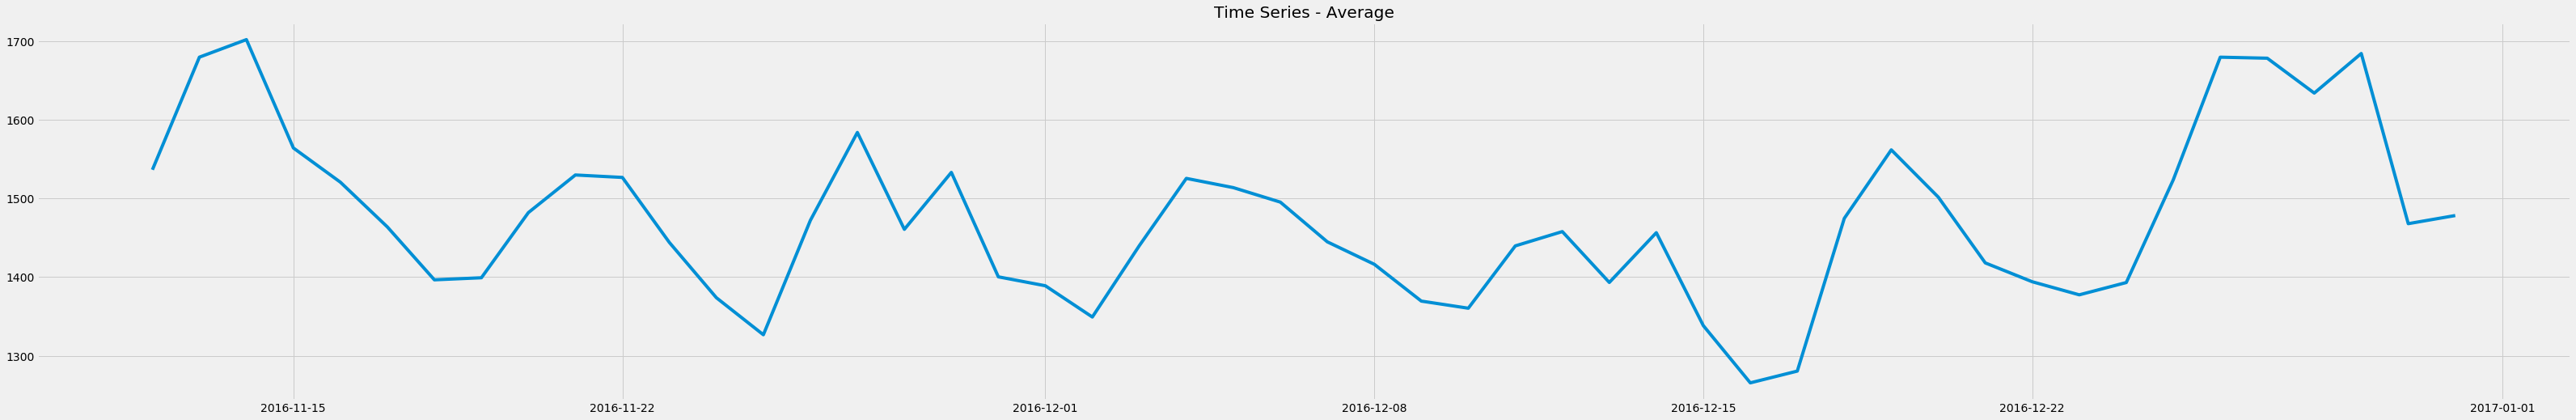

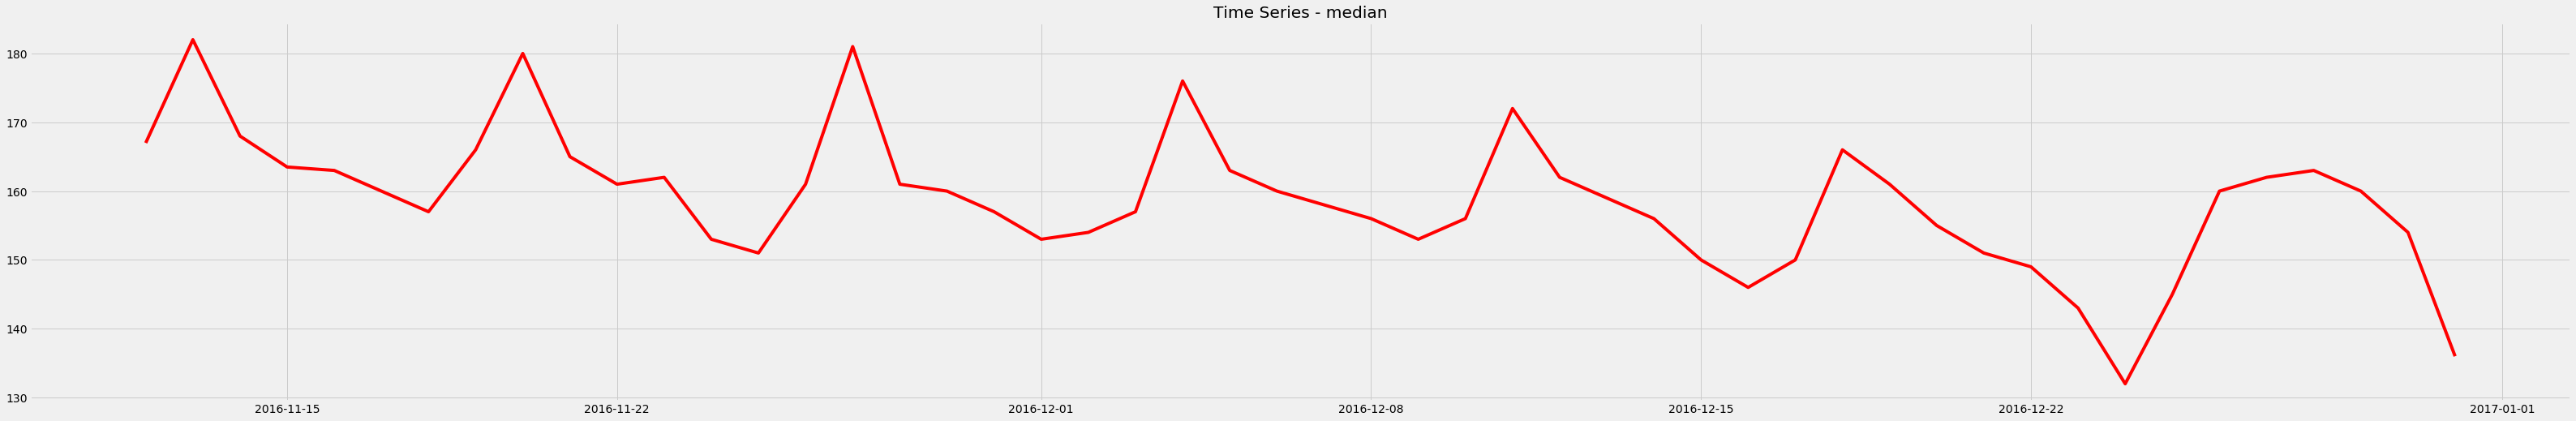

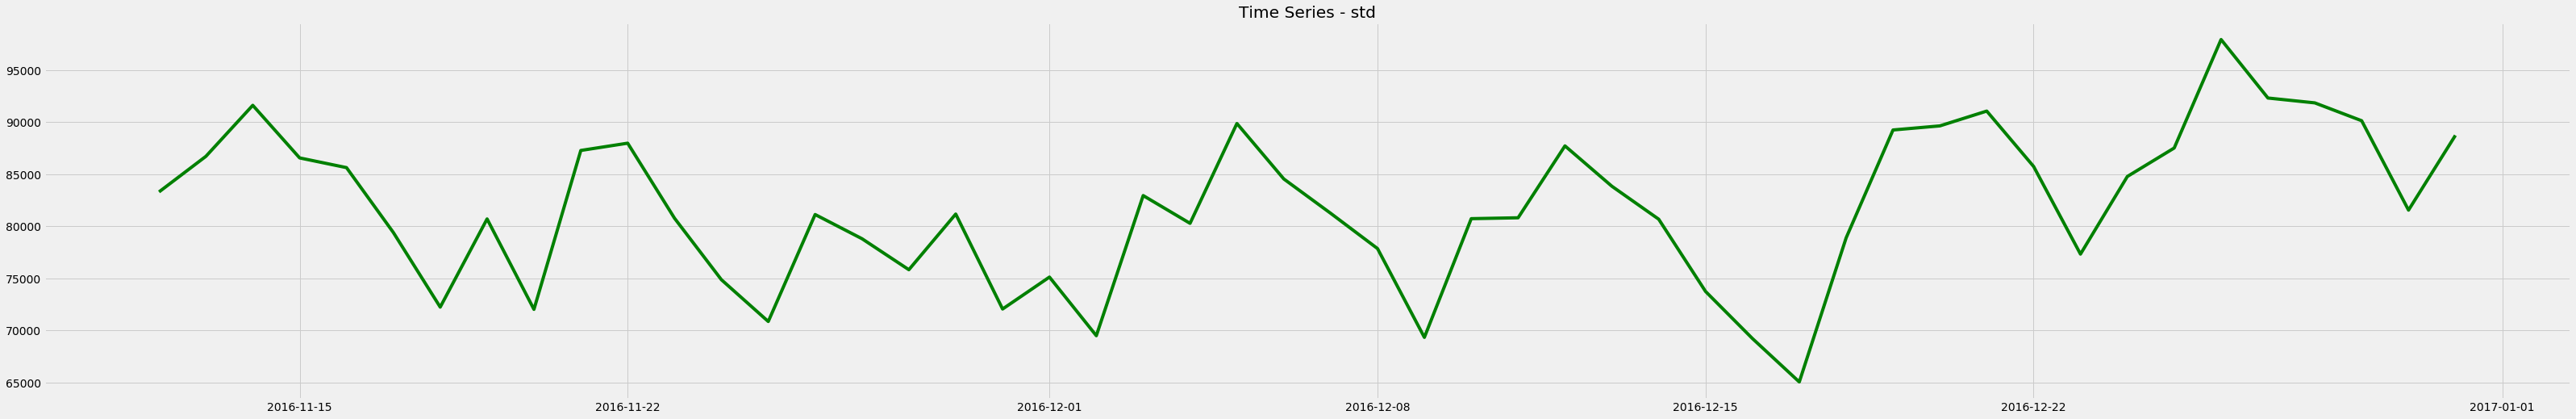

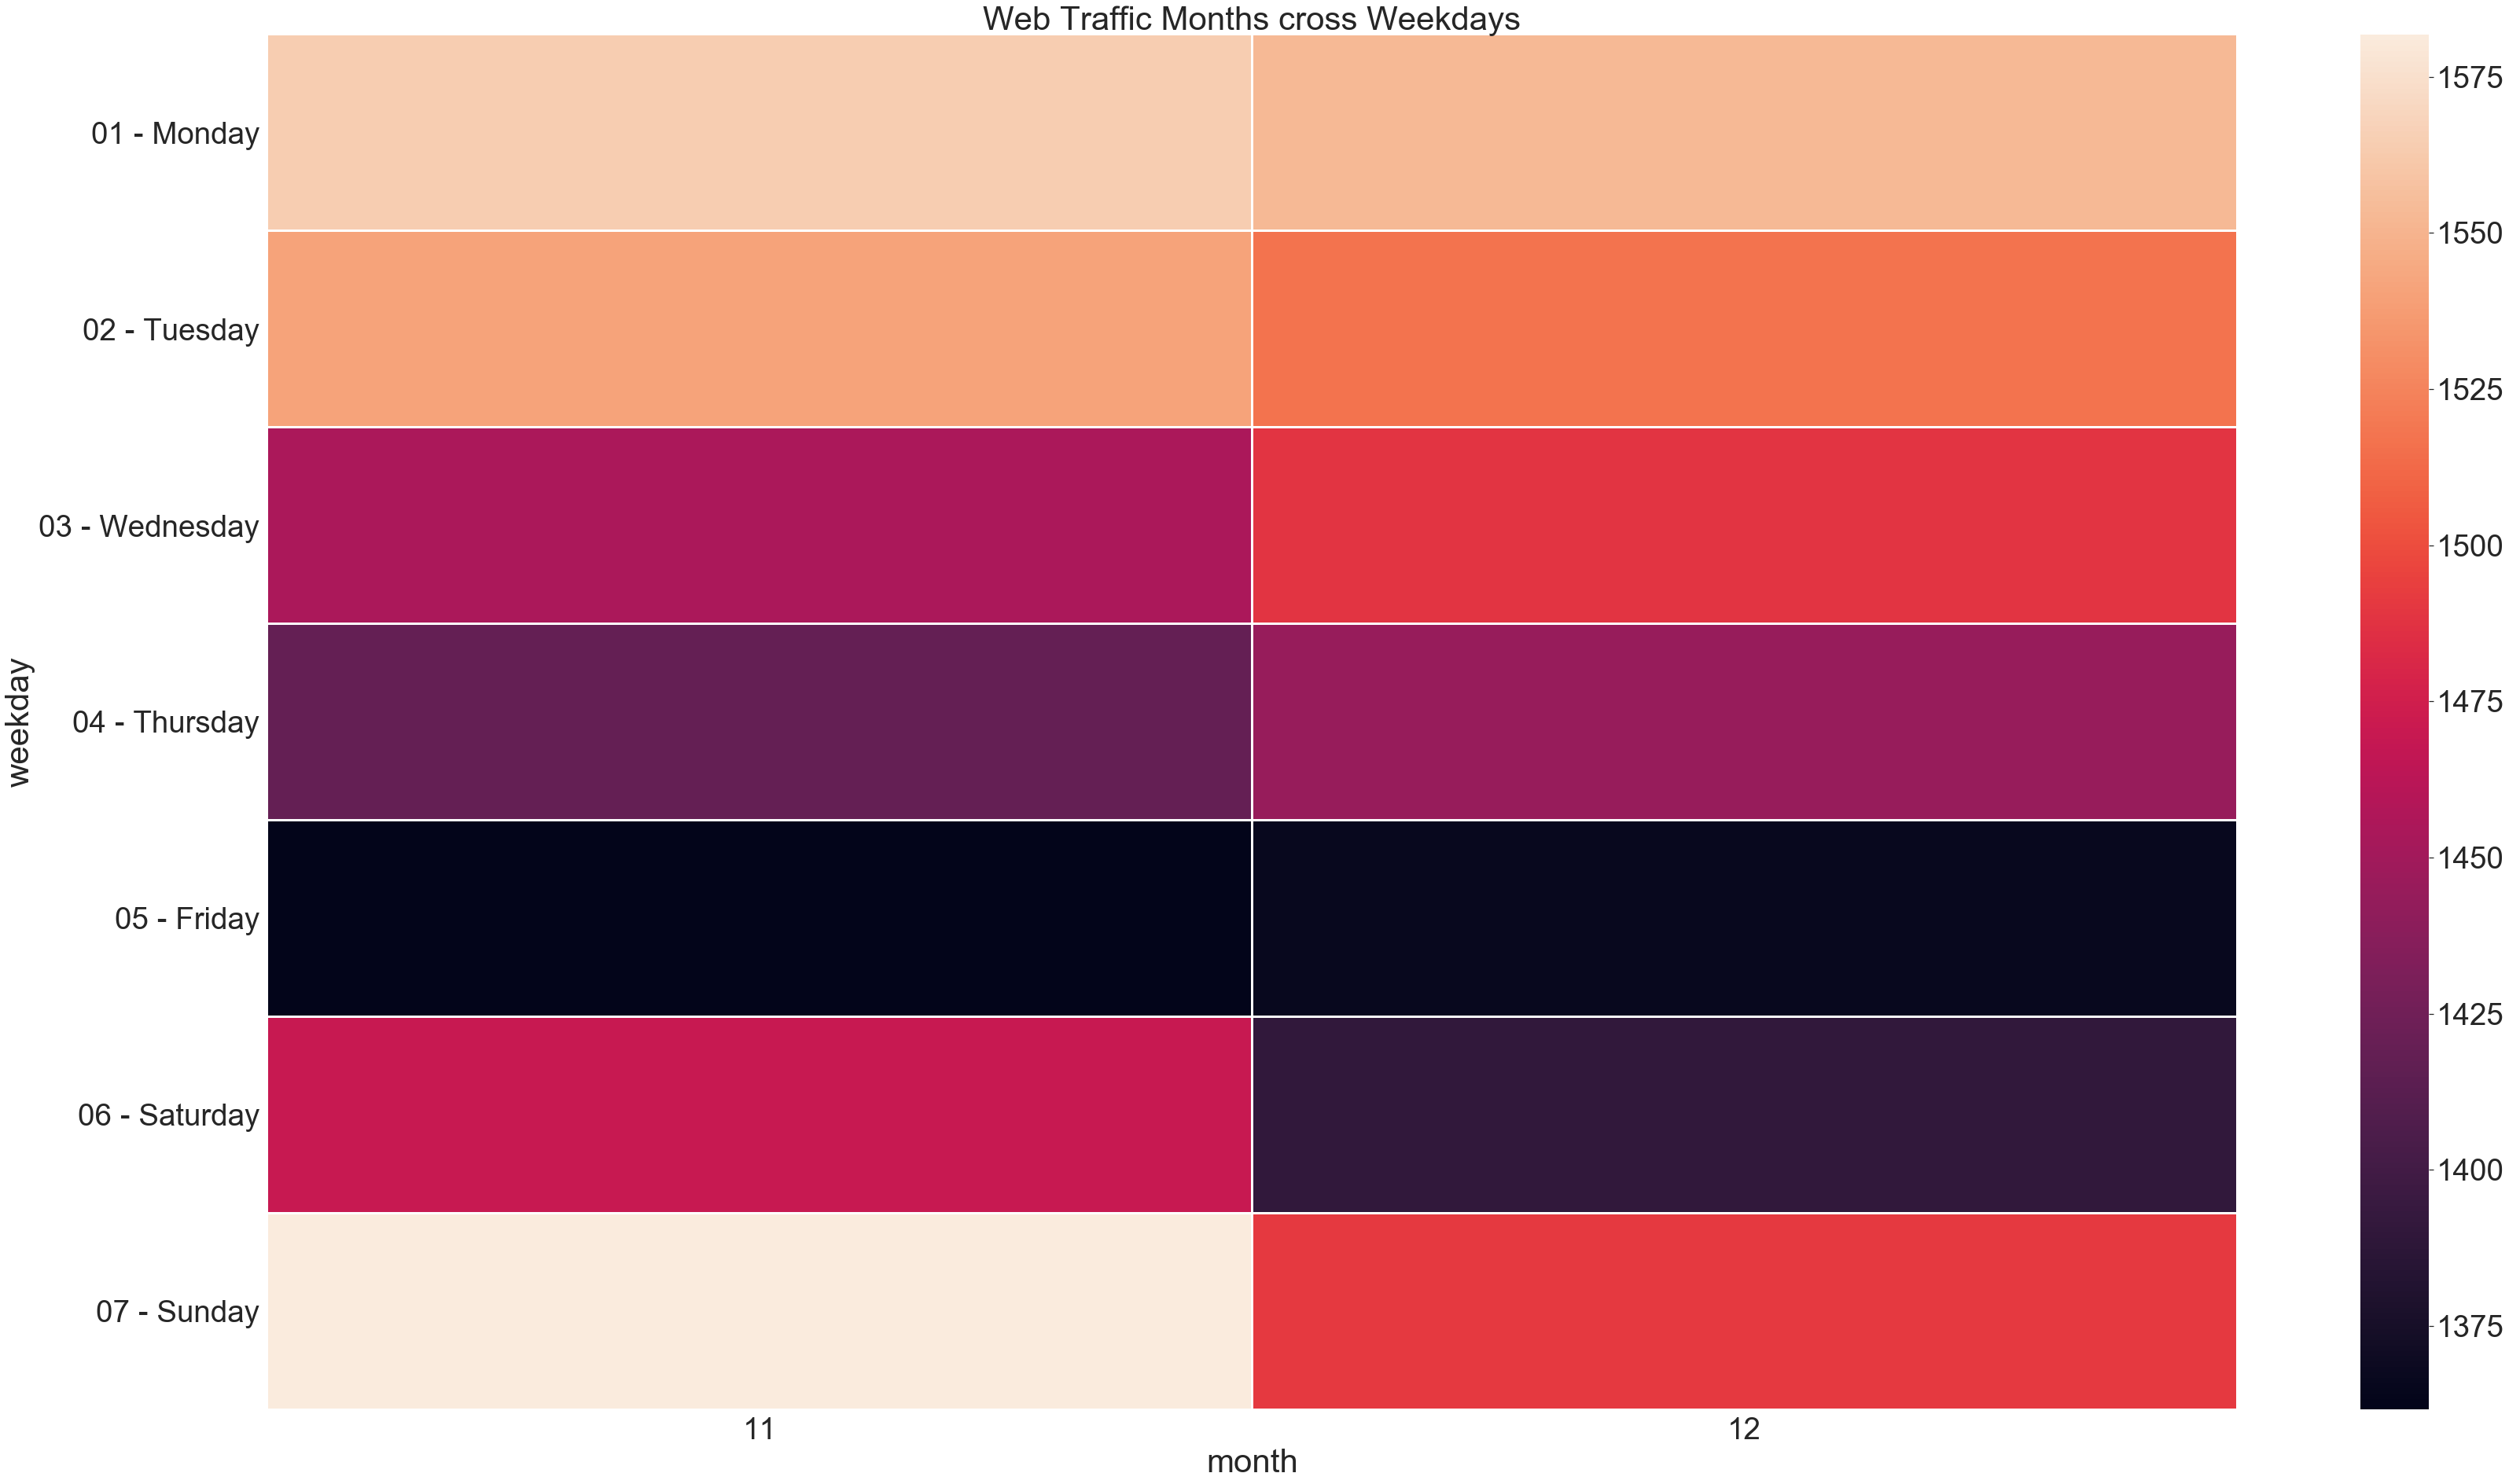

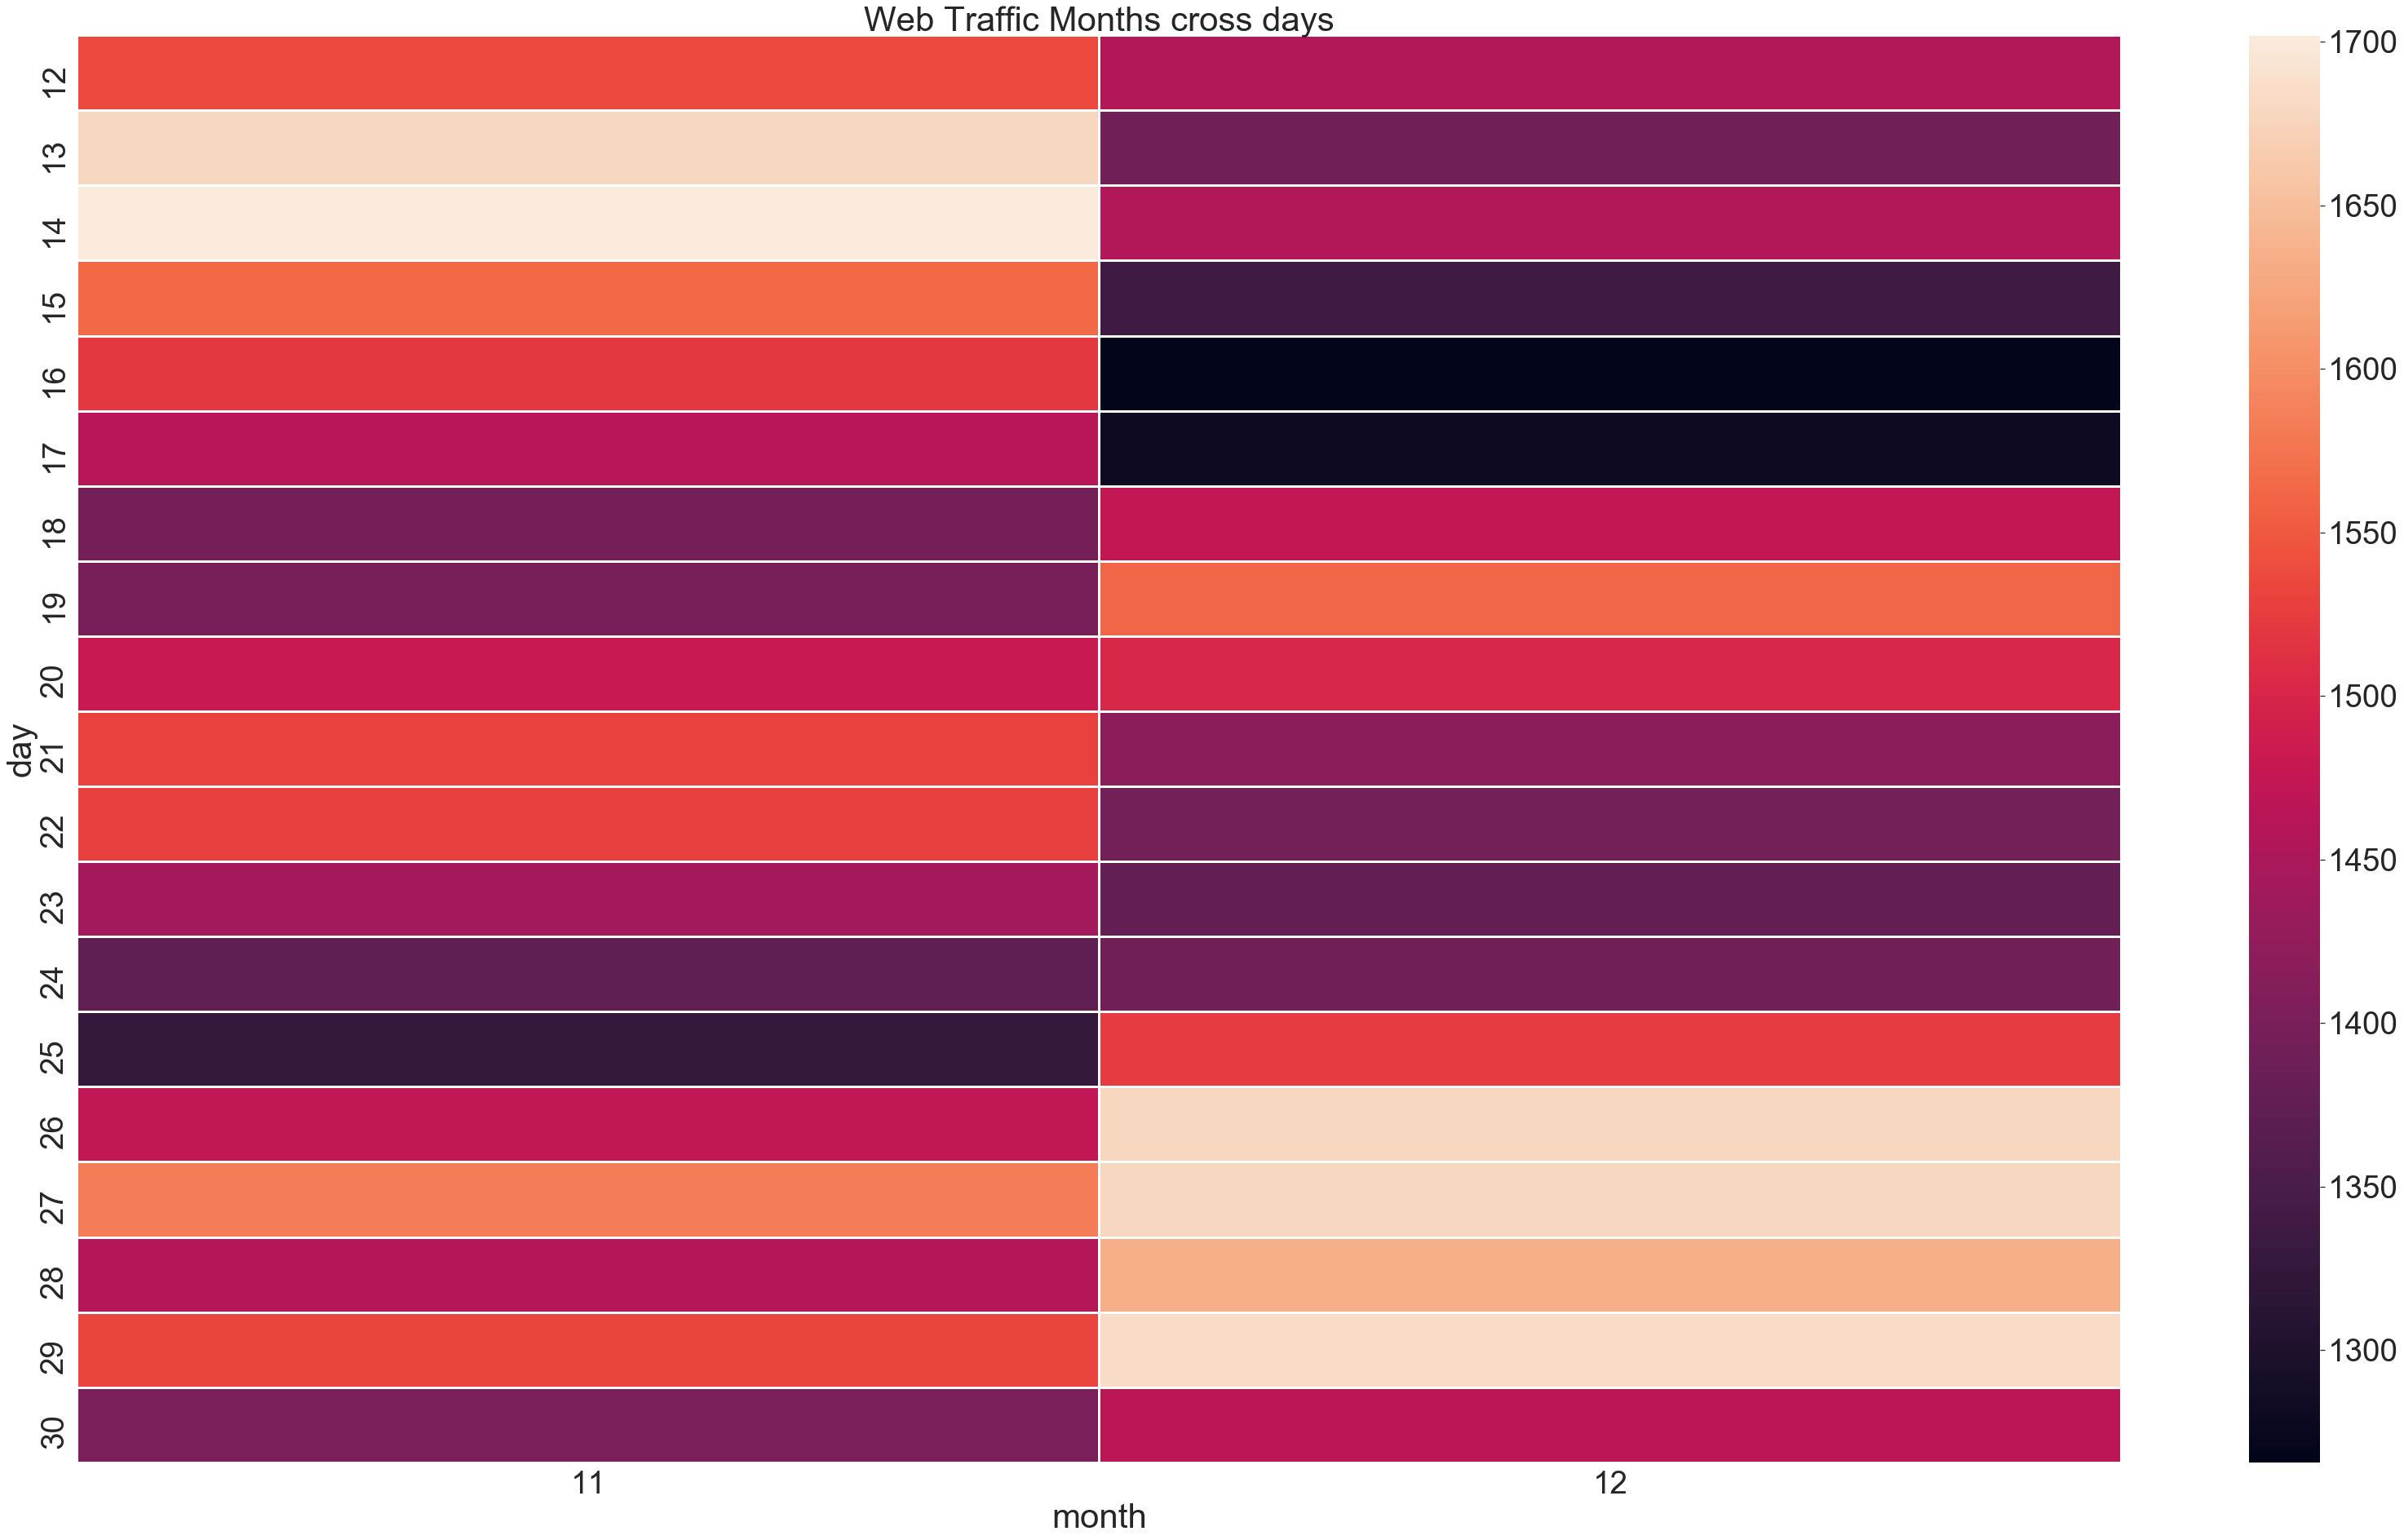

In [31]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()


train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()


In [32]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

date       Visits  weekday  year month day
0 2016-11-12  1536.471757        5  2016    11  12
1 2016-11-13  1679.630589        6  2016    11  13
2 2016-11-14  1701.941831        0  2016    11  14
3 2016-11-15  1564.172228        1  2016    11  15
4 2016-11-16  1520.673959        2  2016    11  16

-----------------------------------------------
mae with 70% of the data to train: 77.19244965544415
-----------------------------------------------


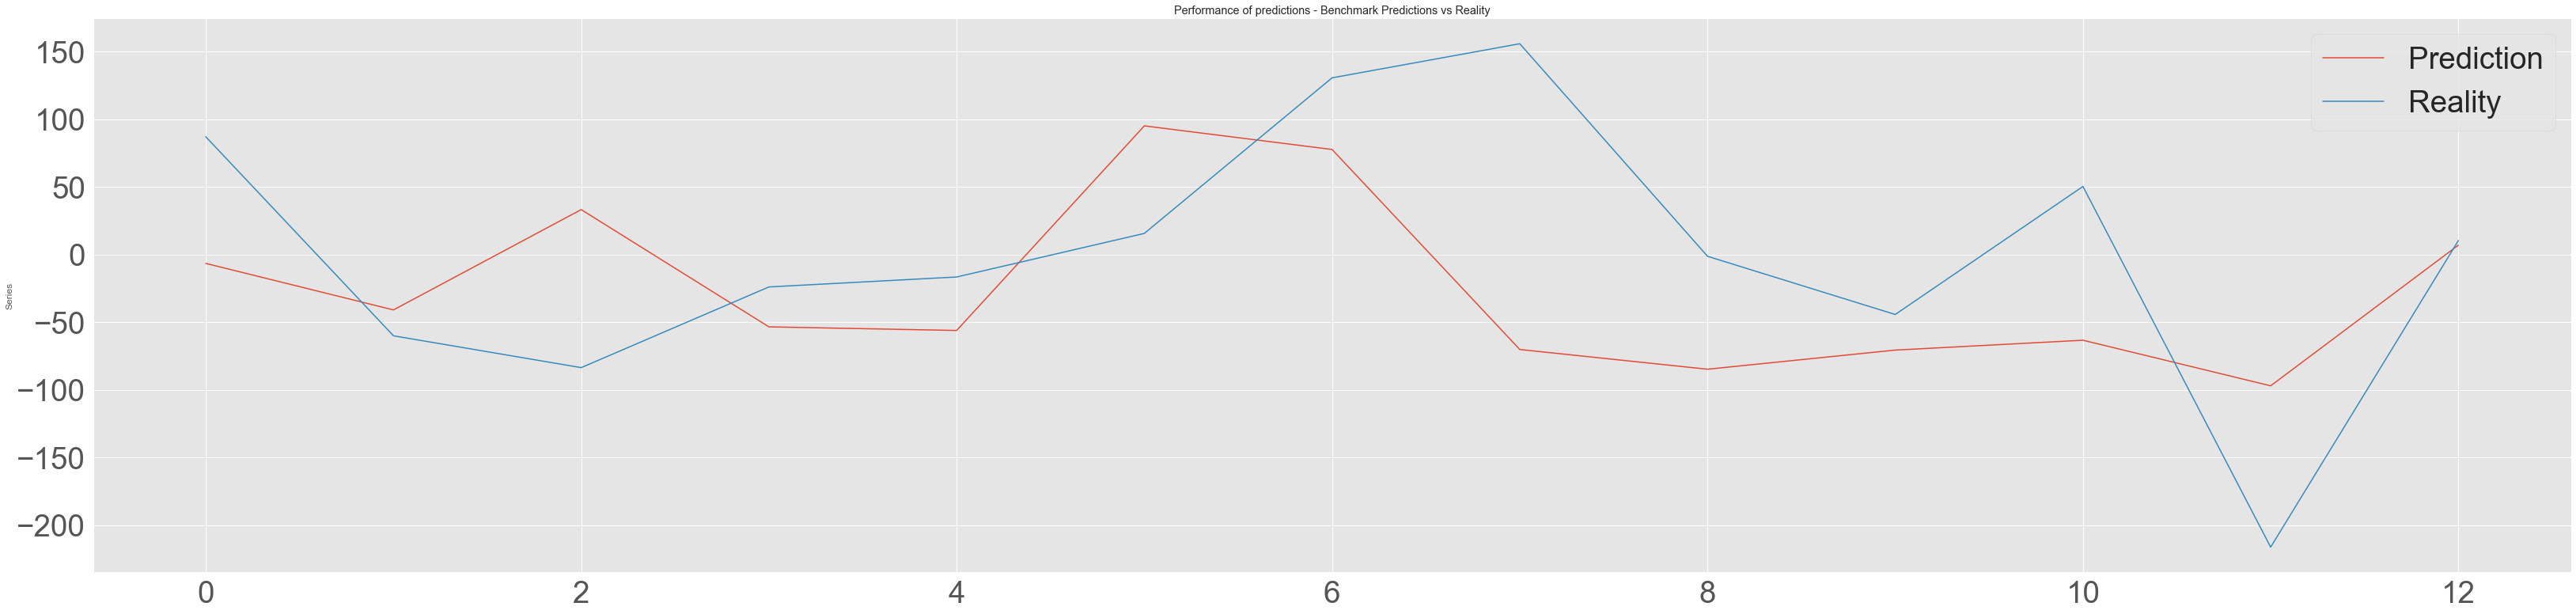

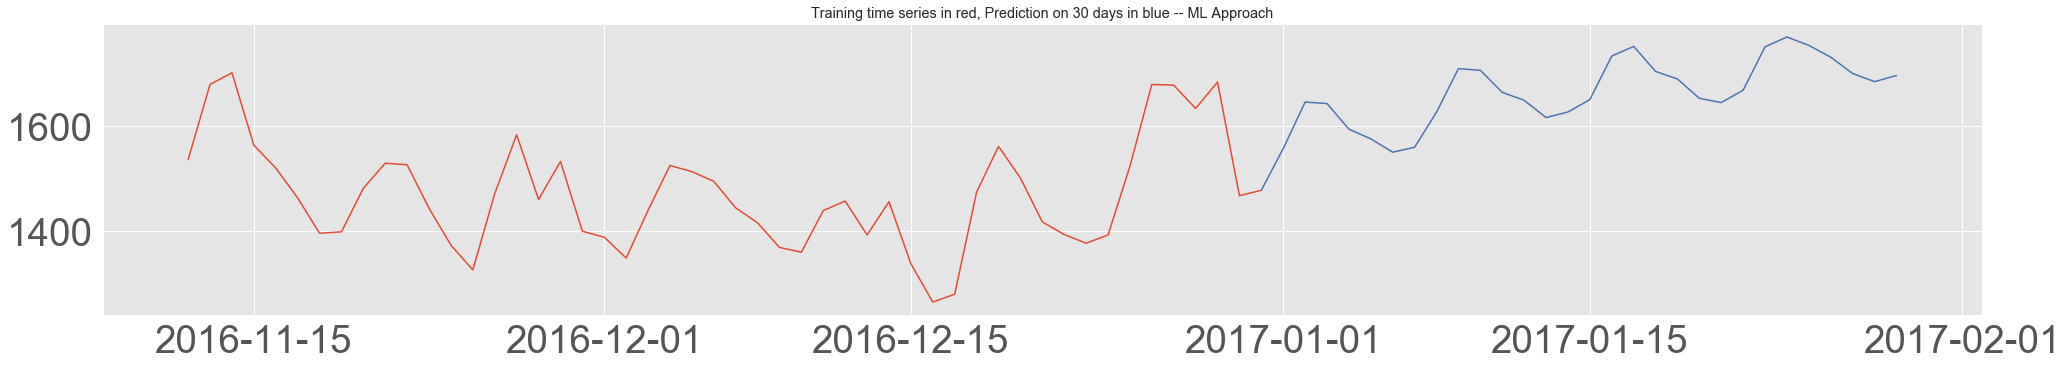

In [33]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data,lag):
    lag = lag
    X = lagmat(data["diff"], lag)
    lagged = data.copy()
    for c in range(1,lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.loc[1:, "diff"] = (data.iloc[1:, 1].values - data.iloc[:len(data)-1, 1].values)
    return data

df_count = diff_creation(times_series_means)

# Creation of 7 features with "diff"
lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

lagged.head()

# Train Test split
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1,lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]["diff"]
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

# Linear Model
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    # Modelisation with all product
    model0.fit(x_tr, y_tr)

    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.values, model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.values, model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    # Model with all data
    model1.fit(xt, yt) 
    
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0  = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

# Performance 1
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction,label='Prediction')
line_down, = plt.plot(np.array(y_test),label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

# Prediction
def pred_df(data,number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred

data_to_pred = pred_df(df_count,30)

def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    # Initialisation
    model.fit(xtrain, ytrain)
    
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])

        # Loop
        if i == 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]

        if i > 0 :
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
        
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        
        # test
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        
    return data_lag

model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

lagged[lagged['diff']<0]
lagged.loc[(lagged.Visits < 0), 'Visits'] = 0

df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

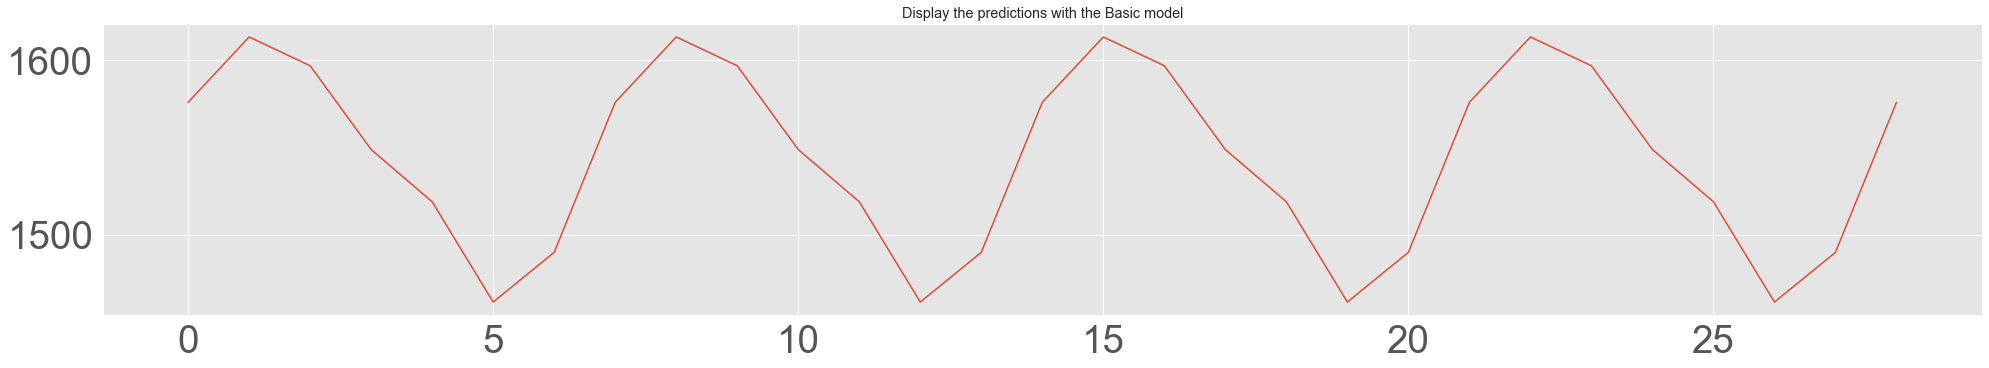

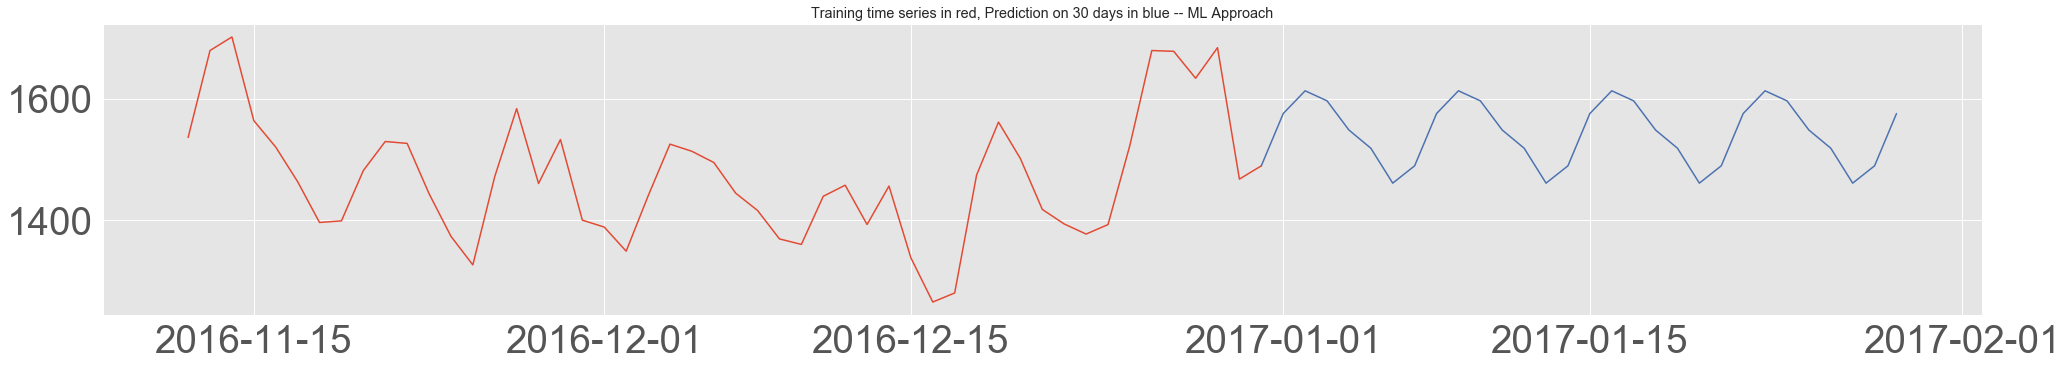

In [34]:

lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr   = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)


prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()
    

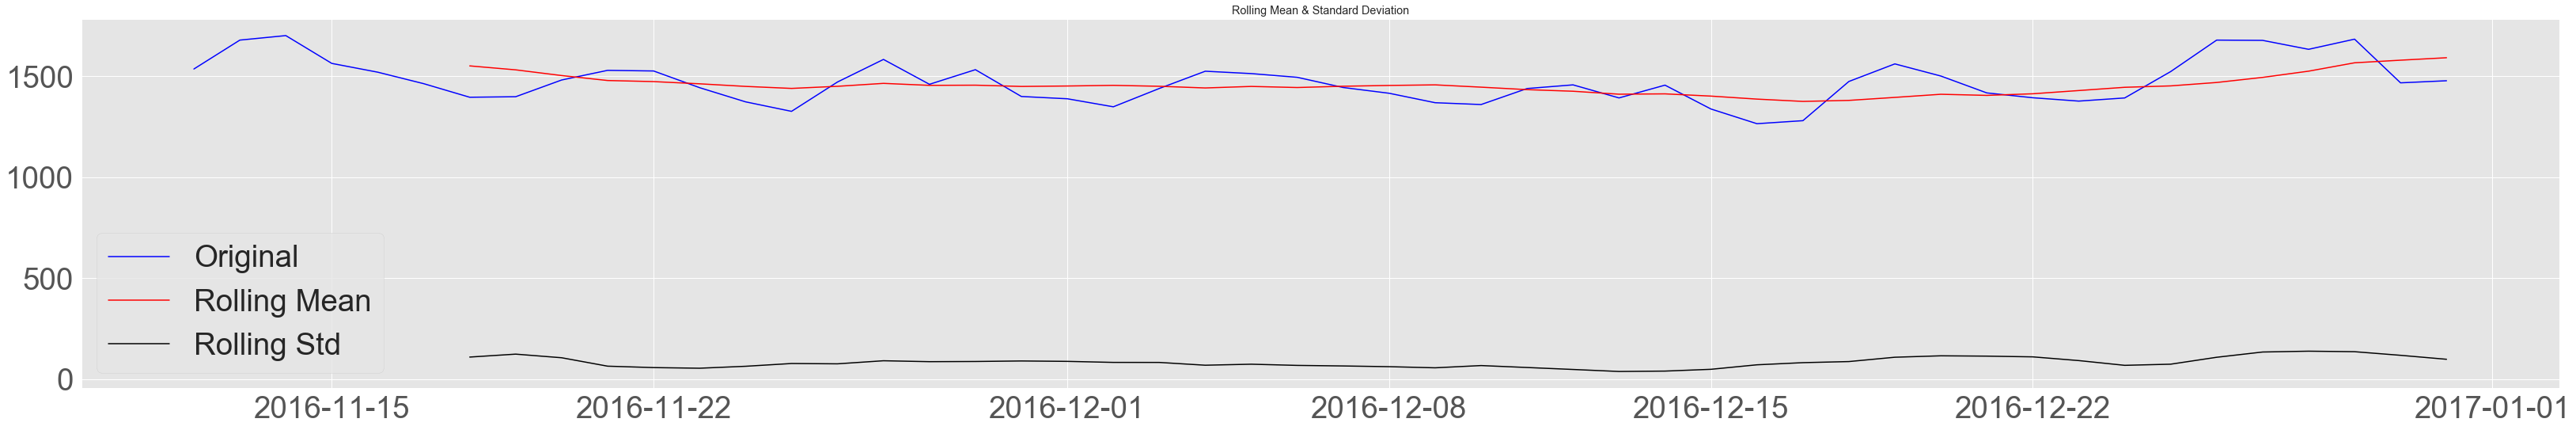

Results of Dickey-Fuller Test:
Test Statistic                 -4.292839
p-value                         0.000457
#Lags Used                      1.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


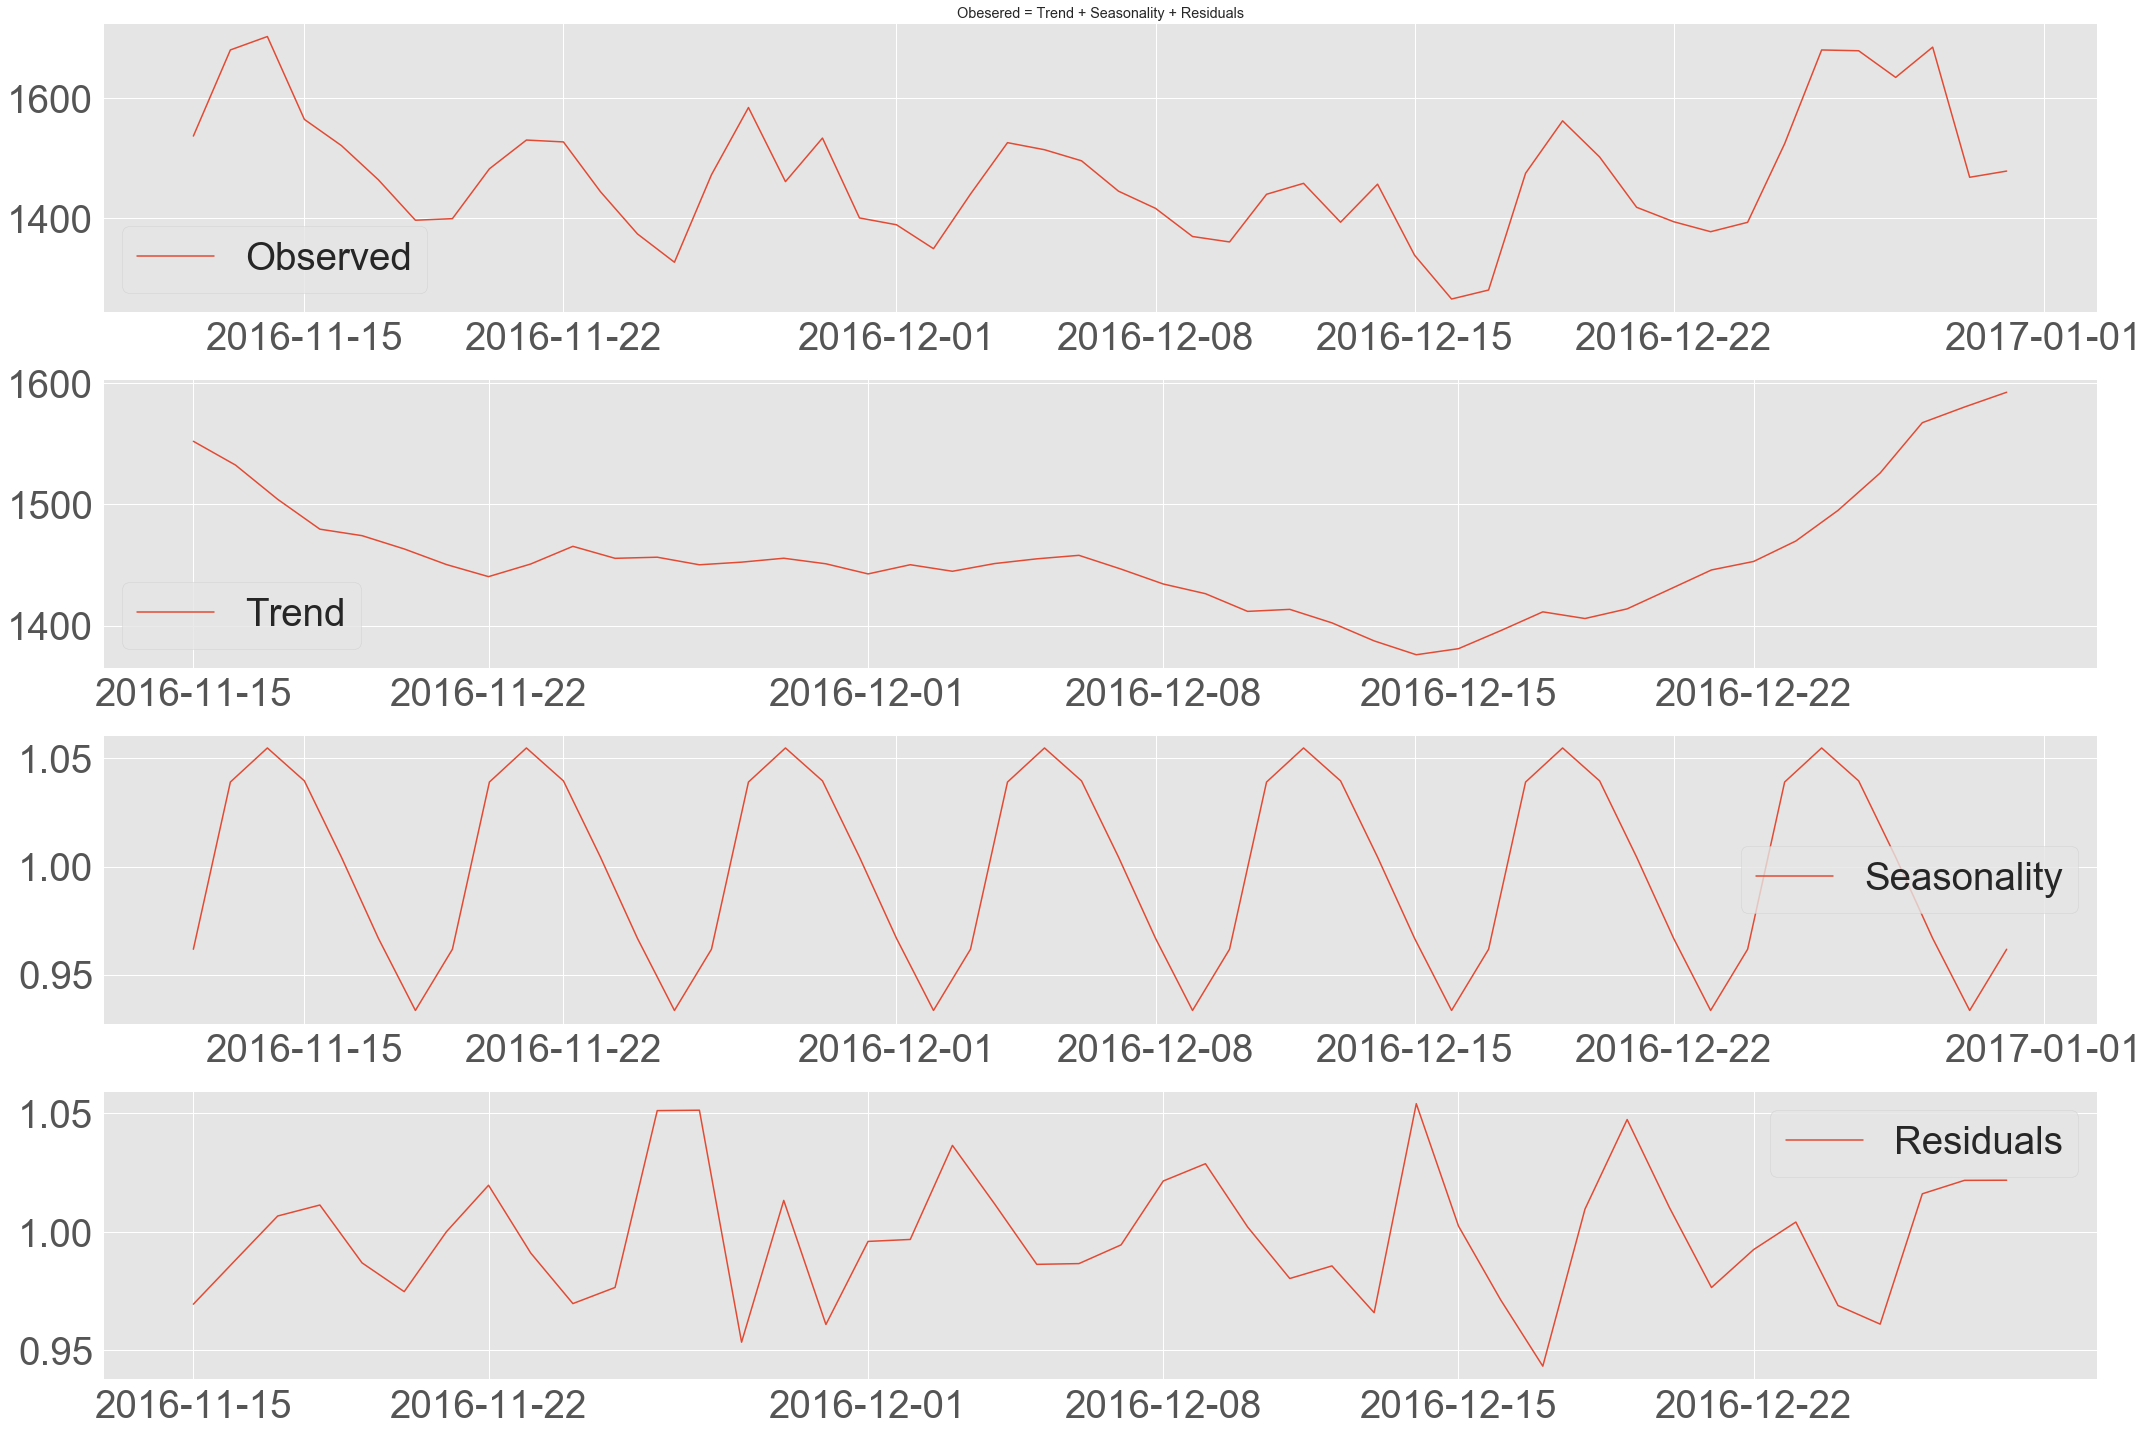

In [35]:
# Show Rolling mean, Rolling Std and Test for the stationnarity
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()    #pd.rolling_mean(timeseries, window=7)
    rolstd = timeseries.rolling(7).std()    #pd.rolling_std(timeseries, window=7)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   


# Naive decomposition of our Time Series as explained above
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [36]:
#from statsmodels.tsa.arima_model import ARIMA

#model = ARIMA(df_date_index, order=(7, 1, 0))  
#results_AR = model.fit(disp=-1)  
#plt.plot(df_date_index, color = 'blue')
#plt.plot(results_AR.fittedvalues, color='red')
#plt.show()

#forecast = results_AR.forecast(steps = 30)[0]
#plt.figure(figsize=(30, 5))
#plt.plot(pd.DataFrame(np.exp(forecast)))
#plt.title('Display the predictions with the ARIMA model')
#plt.show()

# DataFrame to collect the predictions
#df_prediction_arima = df_date_index.copy()

#list_date = []
#for i in range(31):
#    if i >0:
#        list_date.append(last_date  + pd.to_timedelta(i, unit='D'))
    
#predictions_arima = pd.DataFrame(list_date,columns = ['Date'])
#predictions_arima['Visits'] = 0
#predictions_arima.set_index('Date',inplace=True)
#predictions_arima['Visits'] = np.exp(forecast)

#df_prediction_arima = df_prediction_arima.append(predictions_arima)
#df_prediction_arima.reset_index(drop=False,inplace=True)

#df_arima = df_prediction_arima[['Visits','index']]
#df_train = df_arima[df_arima['index'] <= last_date]
#df_pred = df_arima[df_prediction_arima['index'] >= last_date]
#plt.style.use('ggplot')
#plt.figure(figsize=(30, 5))
#plt.plot(df_train.index,df_train.Visits)
#plt.plot(df_pred.index,df_pred.Visits,color='b')
#plt.title('Training time series in red, Prediction on 30 days in blue -- ARIMA Model')
#plt.show()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


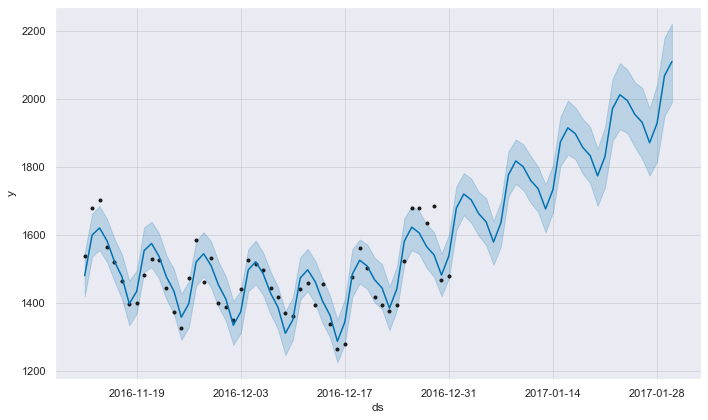

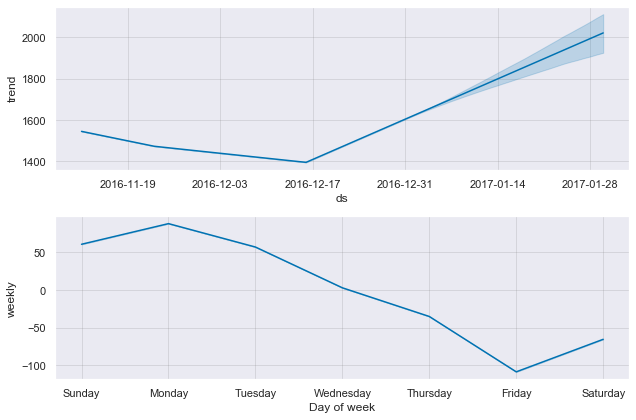

In [37]:
#pip install fbprophet

from fbprophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

m.plot_components(forecast);

40 10
Train Score: 66.19 MSE (66.19 MAE)
Test Score: 83.92 MSE (83.92 MAE)


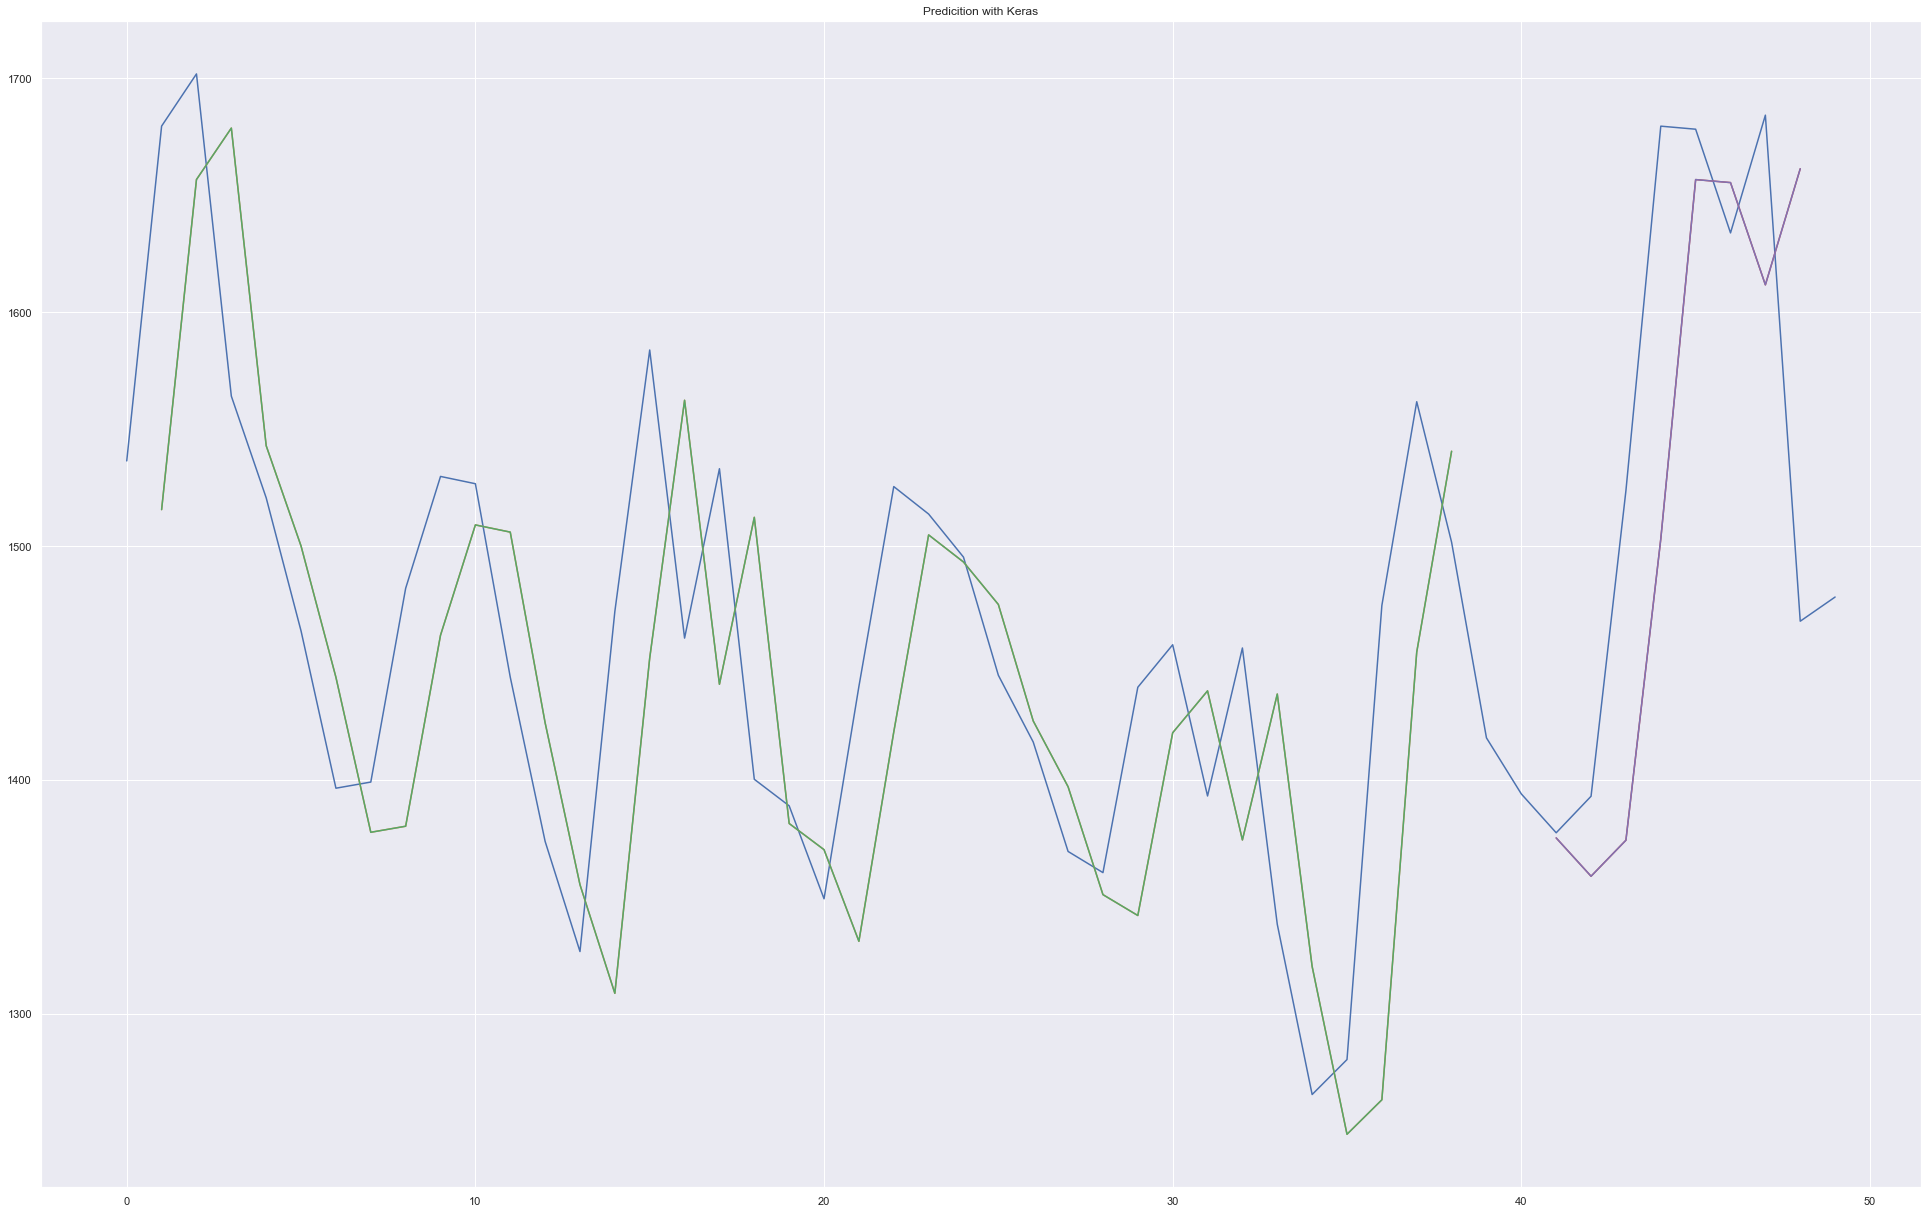

In [38]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))

look_back = 1

def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)

from keras.models import Sequential
from keras.layers import Dense

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_dl)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(np.array(df_dl.Visits))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Predicition with Keras')
plt.show()

# Rossman Store Sales

Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero. Simplifies calculation of rmspe
Join with store
augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
training data processed
Train a XGBoost model
[0]	train-rmse:5.79444	eval-rmse:5.79367	train-rmspe:0.99683	eval-rmspe:0.99682
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06391	eval-rmse:4.06338	train-rmspe:0.98147	eval-rmspe:0.98144
[2]	train-rmse:2.85304	eval-rmse:2.85290	train-rmspe:0.93818	eval-rmspe:0.93810
[3]	train-rmse:2.00947	eval-rmse:2.00981	train-rmspe:0.85676	eval-rmspe:0.85652
[4]	train-r

[94]	train-rmse:0.10246	eval-rmse:0.10794	train-rmspe:0.11743	eval-rmspe:0.11348
[95]	train-rmse:0.10230	eval-rmse:0.10780	train-rmspe:0.11729	eval-rmspe:0.11336
[96]	train-rmse:0.10196	eval-rmse:0.10759	train-rmspe:0.11596	eval-rmspe:0.11312
[97]	train-rmse:0.10172	eval-rmse:0.10736	train-rmspe:0.11569	eval-rmspe:0.11288
[98]	train-rmse:0.10138	eval-rmse:0.10716	train-rmspe:0.11519	eval-rmspe:0.11269
[99]	train-rmse:0.10108	eval-rmse:0.10696	train-rmspe:0.11480	eval-rmspe:0.11249
[100]	train-rmse:0.10080	eval-rmse:0.10684	train-rmspe:0.11452	eval-rmspe:0.11238
[101]	train-rmse:0.10044	eval-rmse:0.10652	train-rmspe:0.11414	eval-rmspe:0.11205
[102]	train-rmse:0.10007	eval-rmse:0.10628	train-rmspe:0.11374	eval-rmspe:0.11178
[103]	train-rmse:0.09983	eval-rmse:0.10617	train-rmspe:0.11345	eval-rmspe:0.11164
[104]	train-rmse:0.09966	eval-rmse:0.10608	train-rmspe:0.11330	eval-rmspe:0.11158
[105]	train-rmse:0.09943	eval-rmse:0.10588	train-rmspe:0.11306	eval-rmspe:0.11135
[106]	train-rmse:0.099

[194]	train-rmse:0.08413	eval-rmse:0.09587	train-rmspe:0.09279	eval-rmspe:0.10018
[195]	train-rmse:0.08403	eval-rmse:0.09581	train-rmspe:0.09262	eval-rmspe:0.10010
[196]	train-rmse:0.08394	eval-rmse:0.09580	train-rmspe:0.09252	eval-rmspe:0.10010
[197]	train-rmse:0.08391	eval-rmse:0.09579	train-rmspe:0.09249	eval-rmspe:0.10010
[198]	train-rmse:0.08382	eval-rmse:0.09573	train-rmspe:0.09234	eval-rmspe:0.10002
[199]	train-rmse:0.08361	eval-rmse:0.09555	train-rmspe:0.09208	eval-rmspe:0.09976
[200]	train-rmse:0.08349	eval-rmse:0.09548	train-rmspe:0.09197	eval-rmspe:0.09970
[201]	train-rmse:0.08341	eval-rmse:0.09543	train-rmspe:0.09174	eval-rmspe:0.09965
[202]	train-rmse:0.08329	eval-rmse:0.09542	train-rmspe:0.09162	eval-rmspe:0.09963
[203]	train-rmse:0.08321	eval-rmse:0.09539	train-rmspe:0.09153	eval-rmspe:0.09961
[204]	train-rmse:0.08311	eval-rmse:0.09536	train-rmspe:0.09140	eval-rmspe:0.09958
[205]	train-rmse:0.08304	eval-rmse:0.09533	train-rmspe:0.09131	eval-rmspe:0.09956
[206]	train-rmse

[294]	train-rmse:0.07532	eval-rmse:0.09204	train-rmspe:0.08091	eval-rmspe:0.09612
[295]	train-rmse:0.07523	eval-rmse:0.09200	train-rmspe:0.08079	eval-rmspe:0.09607
[296]	train-rmse:0.07516	eval-rmse:0.09200	train-rmspe:0.08071	eval-rmspe:0.09606
[297]	train-rmse:0.07507	eval-rmse:0.09197	train-rmspe:0.08061	eval-rmspe:0.09604
[298]	train-rmse:0.07500	eval-rmse:0.09196	train-rmspe:0.08054	eval-rmspe:0.09605
[299]	train-rmse:0.07495	eval-rmse:0.09195	train-rmspe:0.08049	eval-rmspe:0.09606
Validating
RMSPE: 0.096058
Make predictions on the test set


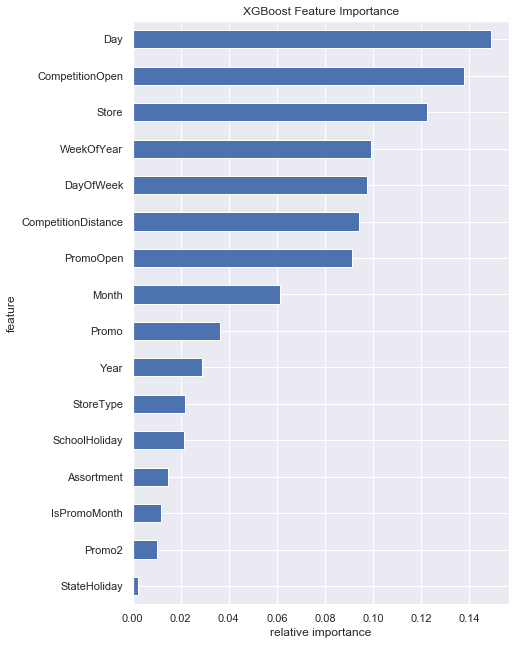

In [39]:
#!/usr/bin/python

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import operator
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import matplotlib.pyplot as plt

path_rossman = 'rossmann-store-sales/input/'

def create_feature_map(features):
    outfile = open(path_rossman+'xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

# Gather some features
def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

## Start of main script

print("Load the training, test and store data using pandas")
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv(path_rossman+"train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv(path_rossman+"test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv(path_rossman+"store.csv")

print("Assume store open, if not provided")
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero. Simplifies calculation of rmspe")
train = train[train["Sales"] > 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
build_features(features, train)
build_features([], test)
print(features)

print('training data processed')

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 300

print("Train a XGBoost model")
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

print("Validating")
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv(path_rossman+"xgboost_10_submission.csv", index=False)

# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code

create_feature_map(features)
importance = gbm.get_fscore(fmap=path_rossman+'xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig(path_rossman+'feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

# Walmart Recruiting - Store Sales Forecasting

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1529.8075
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1540.25
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1533.1175
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1536.98
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1548.1625
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 4

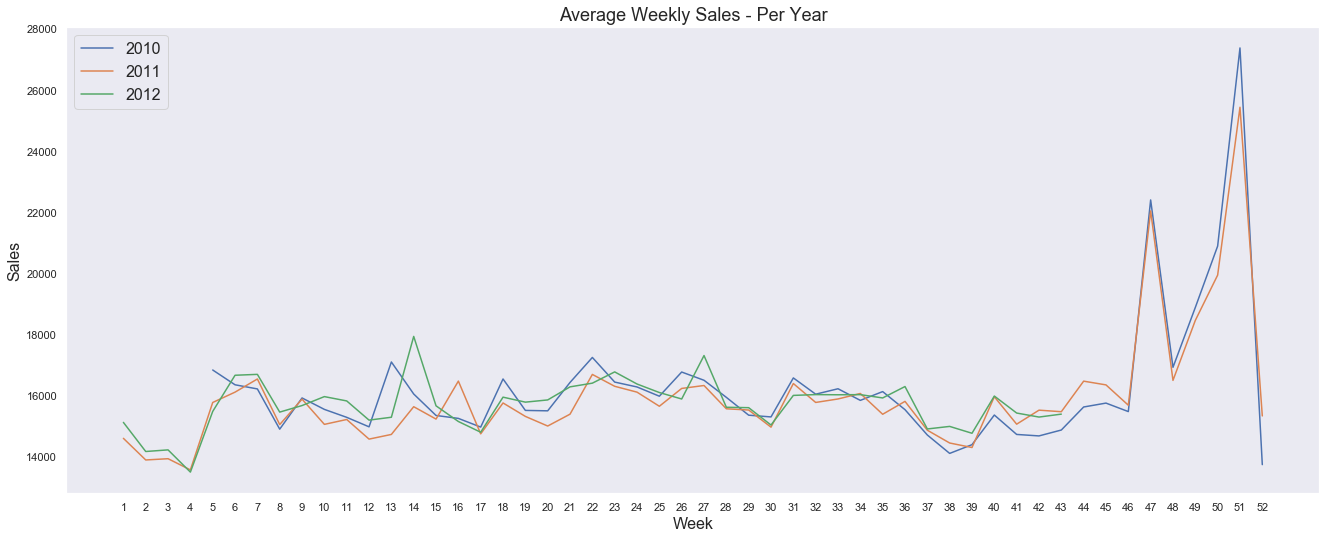

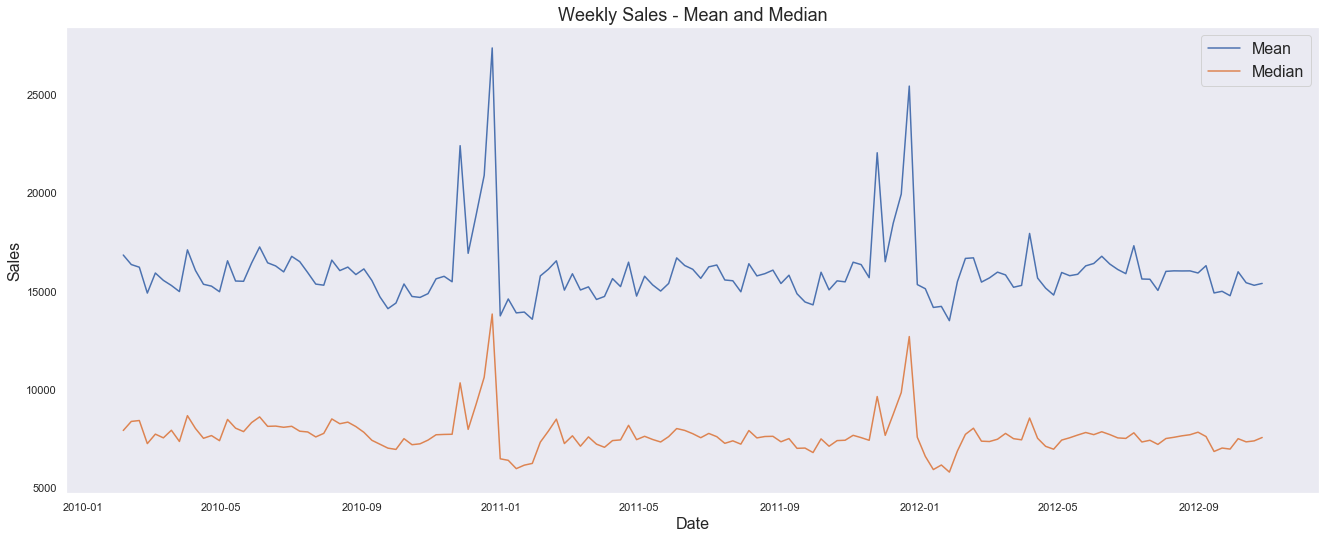

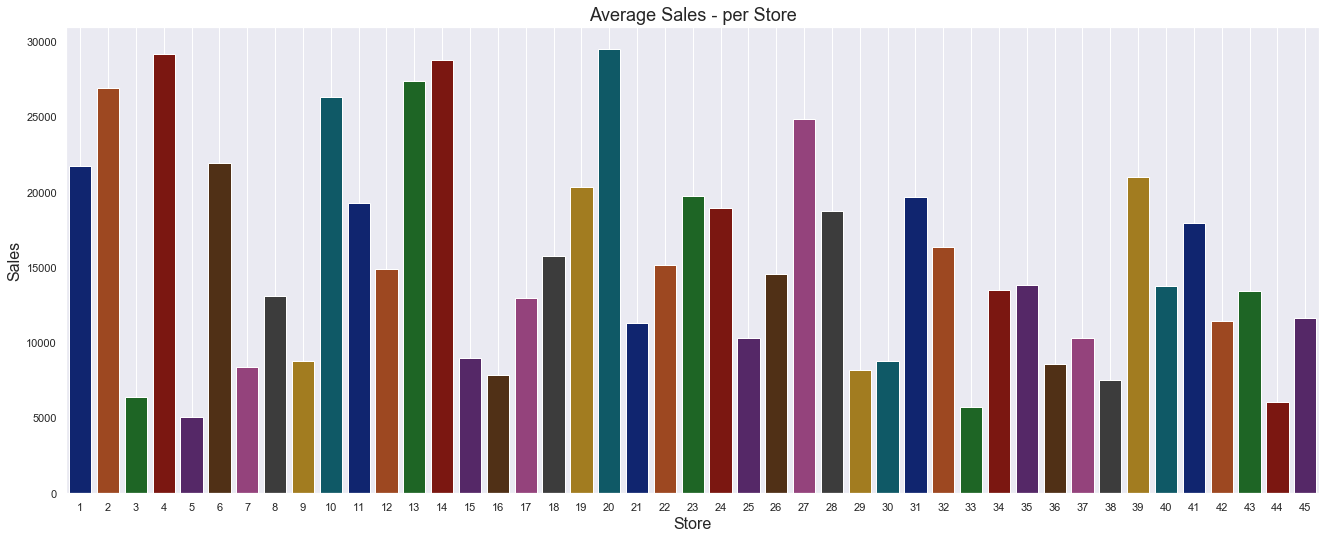

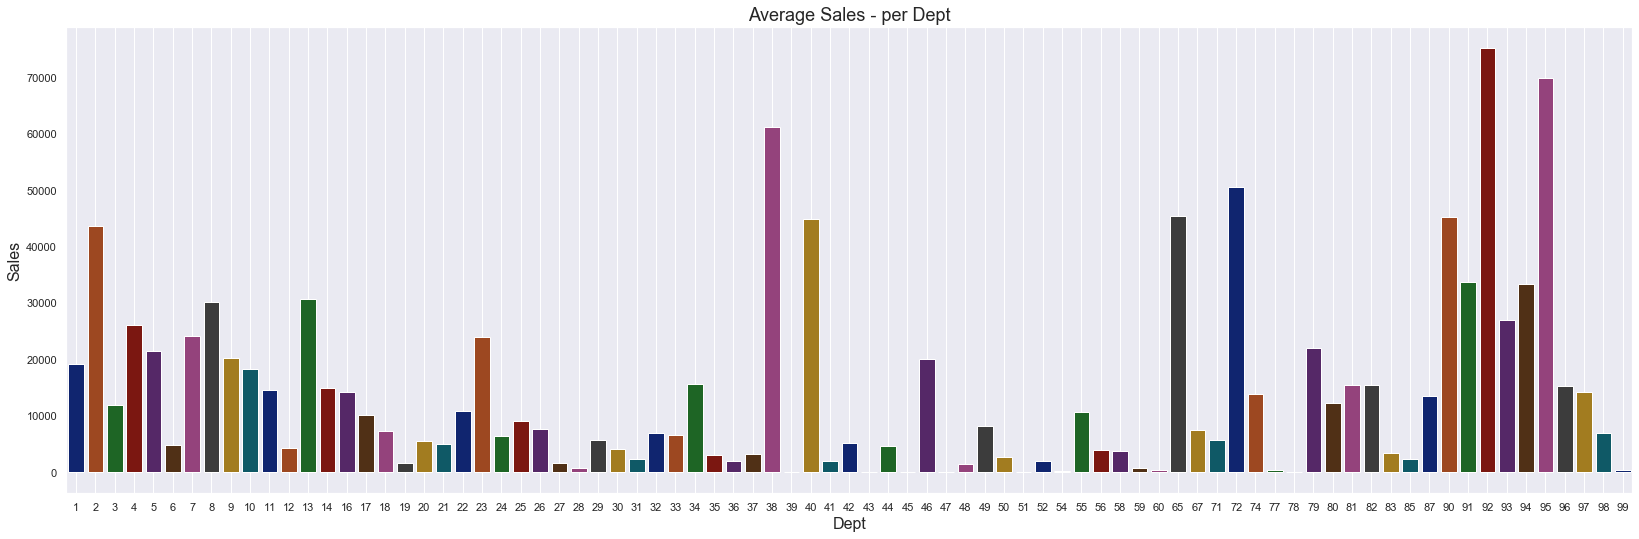

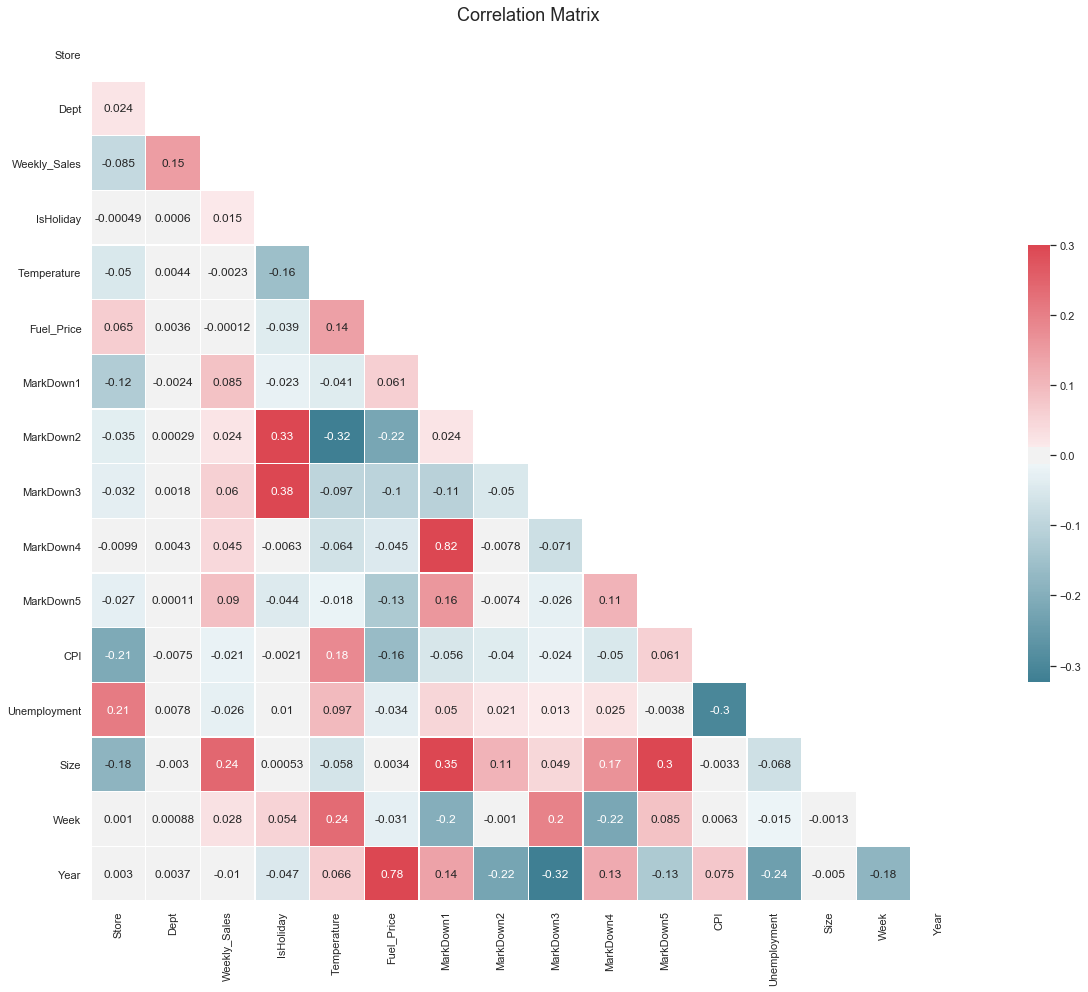

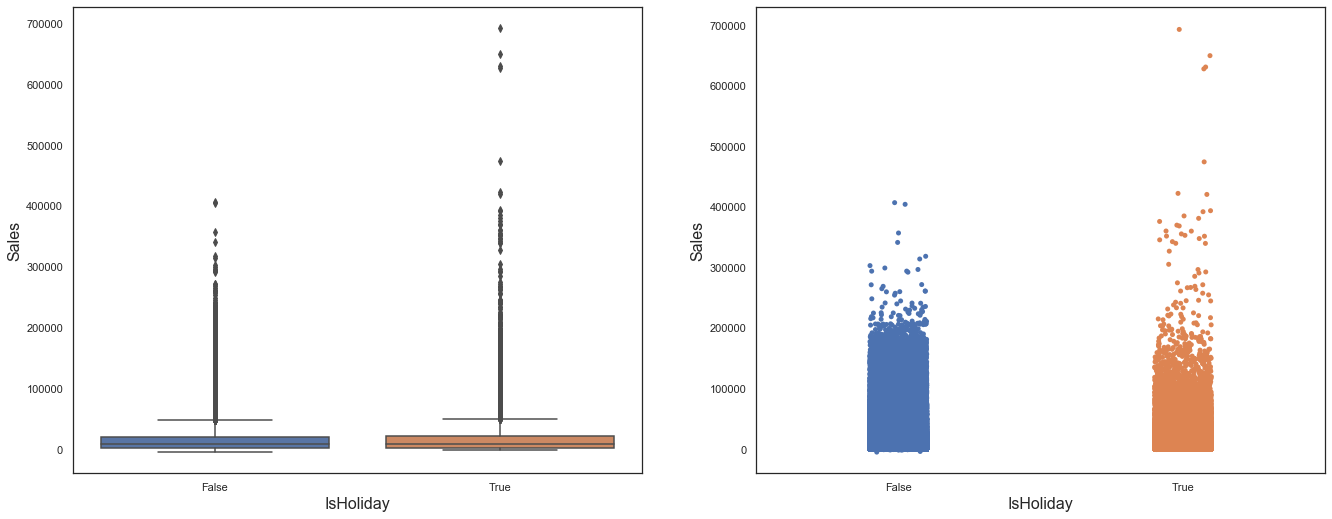

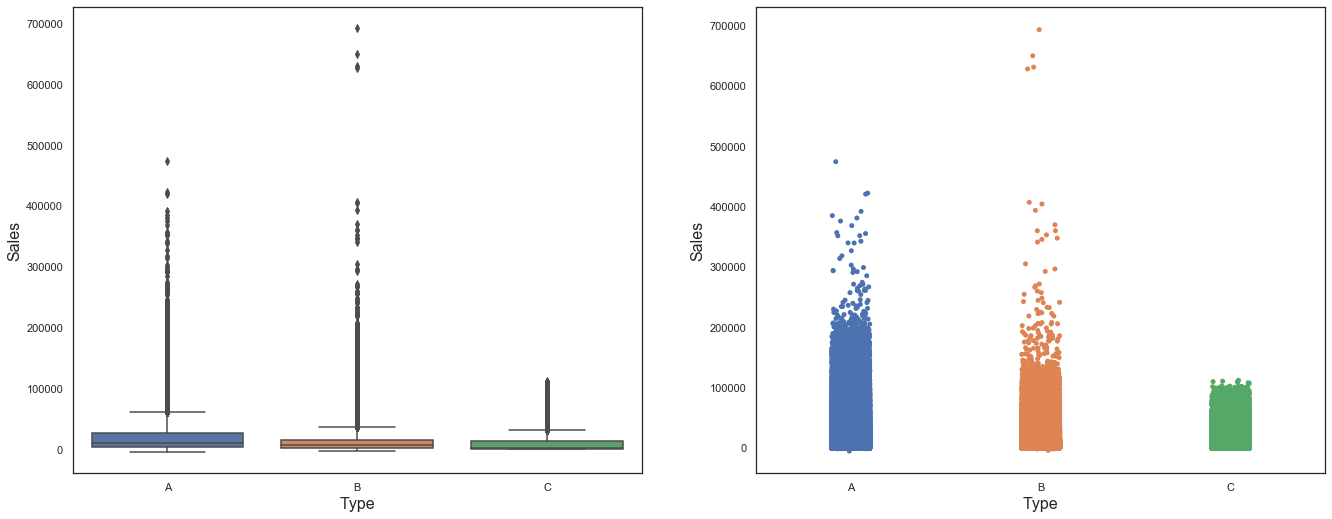

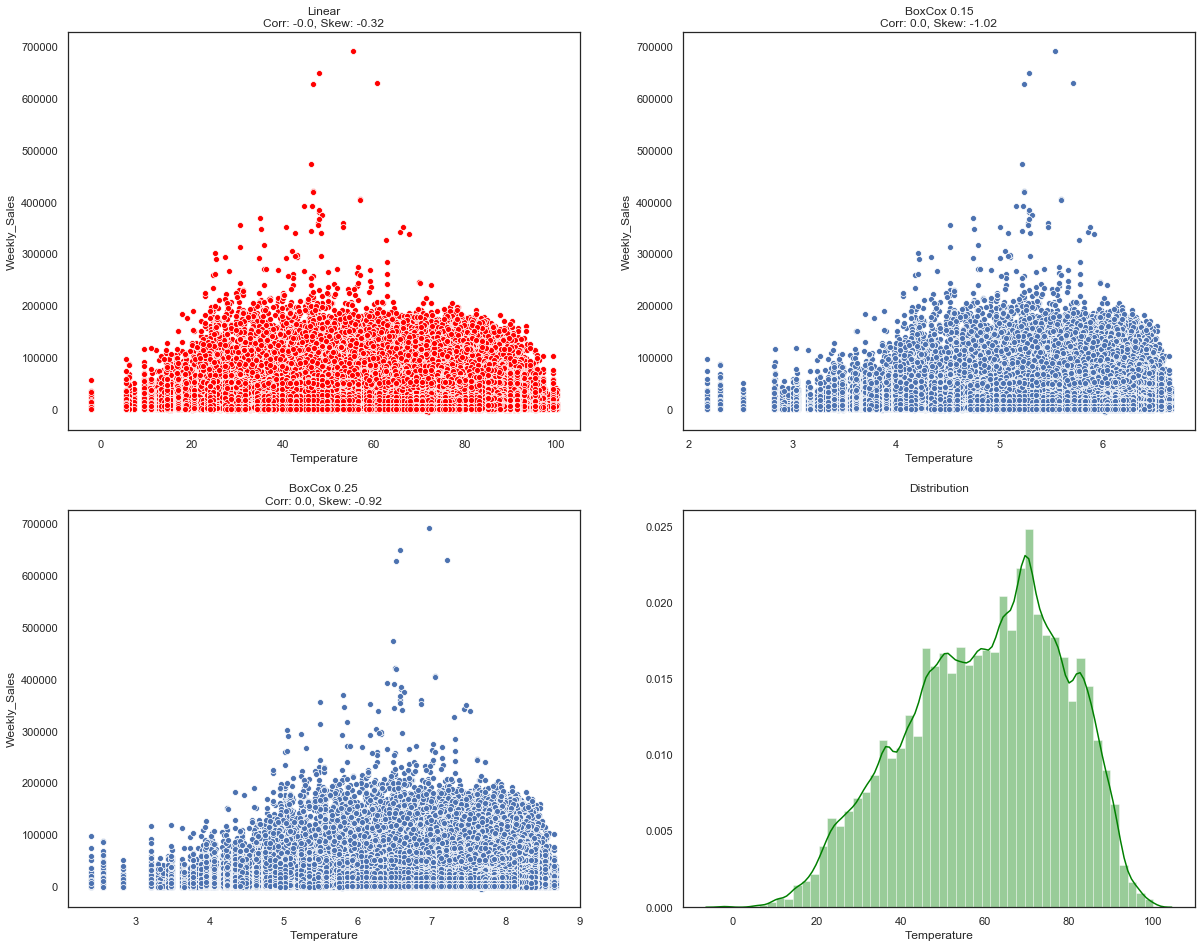

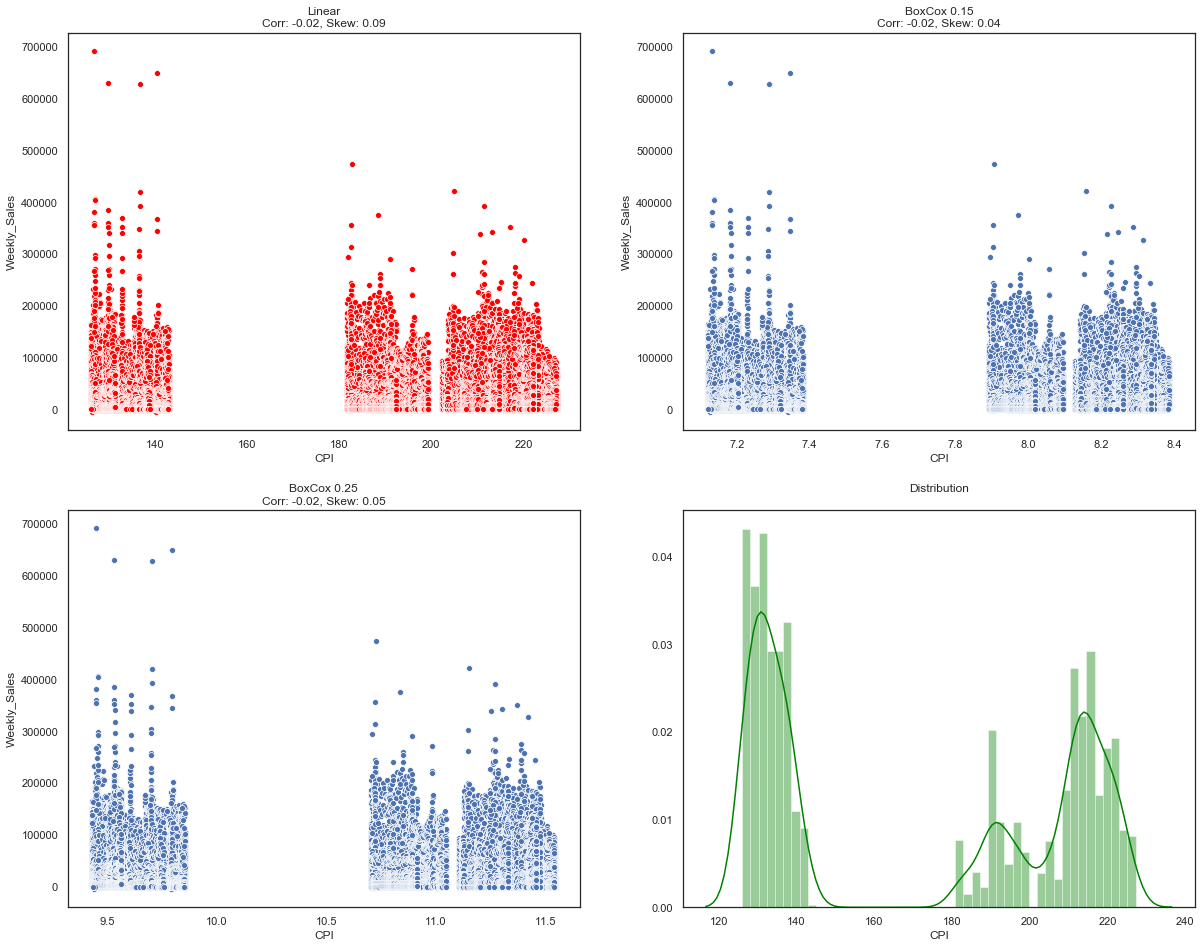

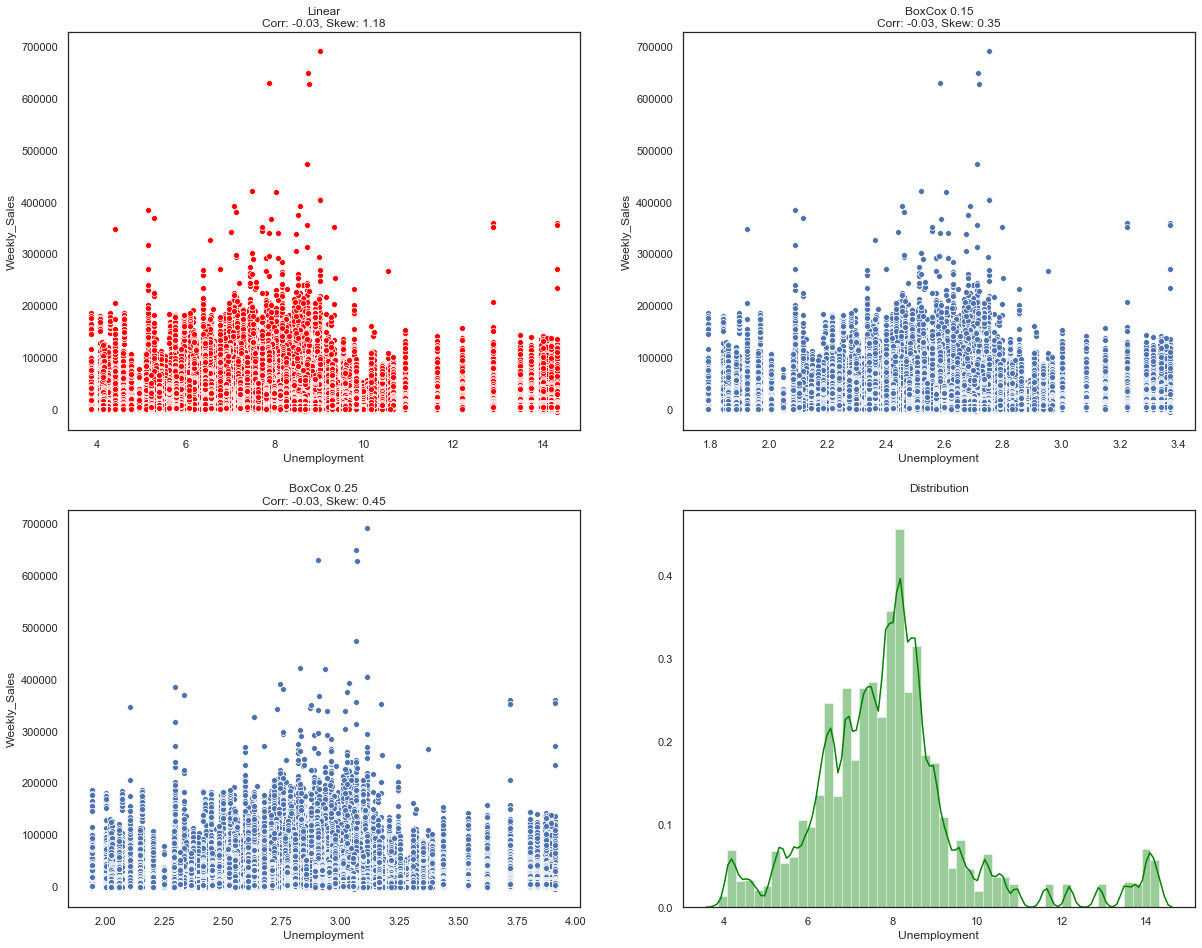

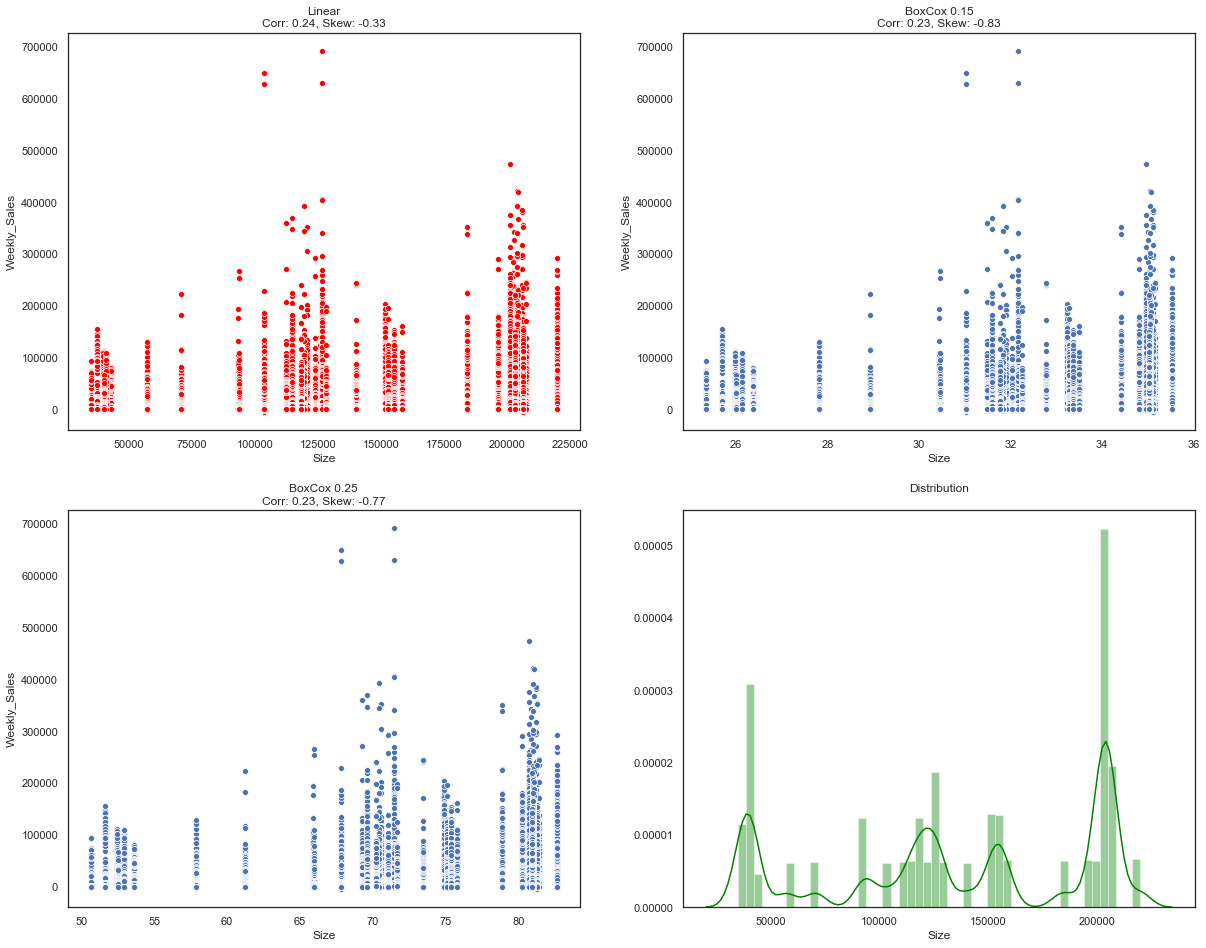

In [40]:
# You will find an overview of what is done at the beginning of each part.

# 1-Libraries and Data Loading

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

path_walmart_rec = 'walmart-recruiting-store-sales-forecasting/input/walmart-recruiting-store-sales-forecasting/'

features = pd.read_csv(path_walmart_rec+'features.csv.zip')
train = pd.read_csv(path_walmart_rec+'train.csv.zip')
stores = pd.read_csv(path_walmart_rec+'stores.csv')
test = pd.read_csv(path_walmart_rec+'test.csv.zip')
sample_submission = pd.read_csv(path_walmart_rec+'sampleSubmission.csv.zip')


feat_sto = features.merge(stores, how='inner', on='Store')

feat_sto.head(5)


pd.DataFrame(feat_sto.dtypes, columns=['Type'])


train.head(5)

pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)


feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year


train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

del features, train, stores, test


null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data


pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")


weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True


weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()


weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()


weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()


sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()


train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])


def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()


make_discrete_plot('IsHoliday')


make_discrete_plot('Type')


train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))



make_continuous_plot('Temperature')


train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])


make_continuous_plot('CPI')


train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])


make_continuous_plot('Unemployment')


train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])


make_continuous_plot('Size')


def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)


def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)


X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']


n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)


max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)


min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)


RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)


X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)


Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")


sample_submission['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']
sample_submission.to_csv(path_walmart_rec+'submission.csv',index=False)

# Walmart Recruiting II: Sales in Stormy Weather
https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather

# M5 Forecasting

https://www.kaggle.com/c/m5-forecasting-accuracy/overview

In [41]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import dask_xgboost as xgb
import dask.dataframe as dd
from sklearn import preprocessing, metrics
import gc
import os

path_m5_forecast = 'm5-forecasting-accuracy/input/'
for dirname, _, filenames in os.walk(path_m5_forecast):
    for filename in filenames:
        print(os.path.join(dirname, filename))

m5-forecasting-accuracy/input/calendar.csv
m5-forecasting-accuracy/input/sales_train_validation.csv
m5-forecasting-accuracy/input/sample_submission.csv
m5-forecasting-accuracy/input/sell_prices.csv
m5-forecasting-accuracy/input/submission.csv


In [42]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    print('Reading files...')
    calendar = pd.read_csv(path_m5_forecast+'calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    sell_prices = pd.read_csv(path_m5_forecast+'sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    sales_train_validation = pd.read_csv(path_m5_forecast+'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    submission = pd.read_csv(path_m5_forecast+'sample_submission.csv')
    return calendar, sell_prices, sales_train_validation, submission


def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 55000000, merge = False):
    
    # melt sales data, get it ready for training
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    # seperate test dataframes
    test1_rows = [row for row in submission['id'] if 'validation' in row]
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test1 = submission[submission['id'].isin(test1_rows)]
    test2 = submission[submission['id'].isin(test2_rows)]
    
    # change column names
    test1.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930', 'd_1931', 
                      'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941']
    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']
    
    # get product table
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()
    
    # merge with product table
    test2['id'] = test2['id'].str.replace('_evaluation','_validation')
    test1 = test1.merge(product, how = 'left', on = 'id')
    test2 = test2.merge(product, how = 'left', on = 'id')
    test2['id'] = test2['id'].str.replace('_validation','_evaluation')
    
    # 
    test1 = pd.melt(test1, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    test2 = pd.melt(test2, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    sales_train_validation['part'] = 'train'
    test1['part'] = 'test1'
    test2['part'] = 'test2'
    
    data = pd.concat([sales_train_validation, test1, test2], axis = 0)
    
    del sales_train_validation, test1, test2
    
    # get only a sample for fst training
    data = data.loc[nrows:]
    
    # drop some calendar features
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    
    # delete test2 for now
    data = data[data['part'] != 'test2']
    
    if merge:
        # notebook crash with the entire dataset (maybee use tensorflow, dask, pyspark xD)
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day'], inplace = True, axis = 1)
        # get the sell price data (this feature should be very important)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    else: 
        pass
    
    gc.collect()
    
    return data
        
calendar, sell_prices, sales_train_validation, submission = read_data()
data = melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 27500000, merge = True)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Our final dataset to train has 31681090 rows and 18 columns


In [43]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
        
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

def simple_fe(data):
    
    # rolling demand features
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    data['rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
    data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
    
    # price features
    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    # time features
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    
    return data

def run_lgb(data):
    
    # going to evaluate with the last 28 days
    x_train = data[data['date'] <= '2016-03-27']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
    y_val = x_val['demand']
    test = data[(data['date'] > '2016-04-24')]
    del data
    gc.collect()

    # define random hyperparammeters
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'n_jobs': -1,
        'seed': 236,
        'learning_rate': 0.1,
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75}

    train_set = lgb.Dataset(x_train[features], y_train)
    val_set = lgb.Dataset(x_val[features], y_val)
    
    del x_train, y_train

    model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)
    val_pred = model.predict(x_val[features])
    val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
    print(f'Our val rmse score is {val_score}')
    y_pred = model.predict(test[features])
    test['demand'] = y_pred
    return test

def predict(test, submission):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.to_csv(path_m5_forecast+'submission.csv', index = False)
    

# define list of features
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30']


def transform_train_and_eval(data):
    data = transform(data)
    data = simple_fe(data)
    # reduce memory for new features so we can train
    #data = reduce_mem_usage(data)
    test = run_lgb(data)
    predict(test, submission)
    
transform_train_and_eval(data)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.38859	valid_1's rmse: 2.1301
[200]	training's rmse: 2.33684	valid_1's rmse: 2.12384
[300]	training's rmse: 2.30156	valid_1's rmse: 2.12181
Early stopping, best iteration is:
[273]	training's rmse: 2.3099	valid_1's rmse: 2.11986
Our val rmse score is 2.1198625270730975
